# Importation
***

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import f1_score , accuracy_score , confusion_matrix , roc_auc_score , precision_recall_fscore_support , precision_recall_curve
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import IsolationForest , RandomForestClassifier
from tqdm import tqdm
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from IPython.display import clear_output

# Data explaination
***

* `user` : Id of our user
* `search_date` : date and time that user sent a query
* `channel` : how user got access to our site, like via email ad or ads in sites or etc
* `is_mobile` : is our user visiting our site with a mobile phone?
* `is_package` : did our user visit other things we can offer like tour or airplane(bus , train) tickets or etc other than hotels?
* `destination` : Id of desired destination of user
* `checkIn_date` : check in date
* `checkOut_date` : check out date
* `n_adults` : announced number of adults for booking a hotel
* `n_children` : announced number of children for booking a hotel
* `n_rooms` : desired rooms to book
* `hotel_category` : f.e how many stars the hotel has or type of hotel
* `is_booking` : at last did our user booked the hotel we showed him?

In [3]:
myds = pd.read_csv('D:\\datasets\\hotel booking predictor\\hotels\\train.csv')
myds

,user,search_date,channel,is_mobile,is_package,destination,checkIn_date,checkOut_date,n_adults,n_children,n_rooms,hotel_category,is_booking
0,u461899,2019-01-07 00:00:02,c9,False,False,d669,2019-03-14,2019-03-15,2,1,1,g41,False
1,u13796,2019-01-07 00:00:06,c9,False,False,d8821,2019-01-19,2019-01-26,1,0,1,g58,False
2,u1128575,2019-01-07 00:00:06,c9,False,False,d25064,2019-01-19,2019-01-22,1,0,1,g91,False
3,u1080476,2019-01-07 00:00:09,c9,False,True,d7635,2019-05-29,2019-06-05,2,0,1,g10,False
4,u1080476,2019-01-07 00:00:17,c9,False,True,d7635,2019-05-29,2019-06-05,2,0,1,g10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34742970,u553256,2020-11-30 23:59:48,c2,True,True,d45532,2020-12-07,2020-12-08,2,0,1,g48,False
34742971,u529472,2020-11-30 23:59:49,c9,False,False,d8279,2020-12-27,2021-01-02,2,2,1,g18,False
34742972,u18236,2020-11-30 23:59:53,c4,False,False,d20275,2021-04-22,2021-04-25,1,0,1,g5,False
34742973,u10888,2020-11-30 23:59:54,c9,False,False,d19371,2020-12-29,2020-12-30,2,0,1,g17,False


# Functions we'll need
***

i wrote this function for turning categorical columns into integers chunk by chunk. this chunk by chunk  is because how big the data is. by making it chunk by chunk it can run faster

In [8]:
def str_category_to_num(DataSet,category_name,chunk):
    iteration = len(DataSet) / chunk
    if iteration - int(iteration) != 0 :
        iteration += 1
    for repeat in tqdm(range(int(iteration))):
        start = chunk * repeat
        category_list_of_names = list(DataSet[start : start + chunk][category_name].value_counts().index)
        if len(DataSet) > start + chunk:
            for index in DataSet[start : start + chunk].index:
                DataSet[start : start + chunk].loc[index,category_name] = category_list_of_names.index(DataSet[start : start + chunk].loc[index,category_name])
        else:
            for index in DataSet[start: ].index:
                DataSet[start: ].loc[index,category_name] = category_list_of_names.index(DataSet[start: ].loc[index,category_name])

we have 24h a day. this function will separate it to 4, 6h parts. this function turn "yy\mm\dd hh:mm:ss" into "hh:mm:ss" and separate it as i wrote

In [11]:
def time_sep(df , column):  
    df[column] = df[column].astype(dtype = 'timestamp[us][pyarrow]') # "yy\mm\dd hh:mm:ss" into "hh:mm:ss"
    
    part_one = np.logical_and((df[column].dt.hour <= 6) , (0 < df[column].dt.hour)) # between 0AM to 6AM
    part_two = np.logical_and((df[column].dt.hour <= 12) , (6 < df[column].dt.hour)) # between 6AM to 12PM
    part_three = np.logical_and((df[column].dt.hour <= 18) , (12 < df[column].dt.hour)) # between 12PM to 18PM
    part_four = np.logical_and((df[column].dt.hour <= 23) , (18 < df[column].dt.hour)) # between 18PM to 0AM

    one = df.loc[part_one]
    two = df.loc[part_two]
    three = df.loc[part_three]
    four = df.loc[part_four]

    return one , two , three , four

this function turn a column with `True` , `False` values into `1` , `0`.

In [69]:
def bool_to_binary(ds , column):
    return pd.Categorical(ds[column]).codes

In [4]:
Columns_to_drop = [
    ['hotel_category' , 'channel' , 'n_adults' ,  'is_package' , 'n_children' , 'diff_date'] ,
    ['hotel_category' , 'channel' , 'n_adults' ,  'is_mobile' , 'n_children' , 'diff_date'] ,
    ['hotel_category' , 'channel' , 'n_adults' ,  'is_mobile' , 'is_package' , 'diff_date'] ,
    ['hotel_category' , 'channel' , 'n_adults' ,  'is_mobile' , 'is_package' , 'n_children'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'n_children' , 'diff_date'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'is_package' , 'diff_date'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'is_package' , 'n_children'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'is_mobile' , 'diff_date'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'is_mobile' , 'n_children'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'is_mobile' , 'is_package'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'diff_date'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'n_children'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'is_package'] ,
    ['hotel_category' , 'channel' , 'n_adults' , 'is_mobile'] ,
    ['hotel_category' , 'channel' , 'n_adults']
]

this function train a same classifier model on different variations of columns from train set and test them with various metrics and save results on a Dataframe. we test our model ,which we trained ,on these metrics : **[precision , recall , f1 score , confusion matrix , accuracy , roc_score , class 0 accuracy , class 1 accuracy , average accuracy]** . this function get 5 inputs:
* `DataFrame`: Dataframe to apply results to
* `Columns`: columns to drop from dataframe so we can train on different variations
* `Threshold`: the threshold to assign probablities to 0 and 1. for instance if we set threshold 0.5, any values more than 0.5 will be 1 and otherwise
* `train`: train set to train on
* `test`: test set to test on

In [ ]:
def cal_score(DataFrame , Columns , Threshold , train , test):
    # for every variations of columns train a model
    for col in Columns:
        df_ = train.drop(col , axis = 1)
        Test_ = test.drop(col , axis = 1)
        
        # this columns is not binary so if we have it in our columns we have to turn them into binary
        if 'is_mobile' in df_.columns:
            Test_['is_mobile'] = bool_to_binary(ds = Test_ , column = 'is_mobile')

        # same story for this column
        if 'is_package' in df_.columns:
            Test_['is_package'] = bool_to_binary(ds = Test_ , column = 'is_package')
        
        # this is our target but itsnt binary so we will convert this too
        Test_['is_booking'] = bool_to_binary(ds = Test_ , column = 'is_booking')


        X2 = df_.drop(['is_booking'] , axis = 1)
        y2 = df_['is_booking']
        x_test2 = Test_.drop(['is_booking'] , axis = 1)
        y_test2 = Test_['is_booking']


        x_train2 = np.asarray(X2 , dtype = 'float32') # we'll turn'em into float32 cuz our model only works with this kind of dtype
        y_train2 = np.asarray(y2 , dtype = 'float32')

        x_test2 = np.asarray(x_test2 , dtype = 'float32')
        y_test2 = np.asarray(y_test2 , dtype = 'float32')

        shape = x_train2.shape[1] # diffenet variations of columns comes with different shapes

        model2 = keras.Sequential([
            keras.layers.Dense(300 , activation = 'elu' , kernel_initializer = 'he_normal' , input_shape = (shape,)),
            keras.layers.Dense(100 , activation = 'elu' , kernel_initializer = 'he_normal'),
            keras.layers.Dense(200 , activation = 'elu' , kernel_initializer = 'he_normal'),
            # keras.layers.Dense(300 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.6)),
            # keras.layers.Dense(100 , activation = 'elu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.35)),
            # keras.layers.Dense(100 , activation = 'elu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.35)),
            # keras.layers.Dense(200 , activation = 'elu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.5)),
            # keras.layers.Dense(300 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.6)),
            keras.layers.Dense(100 , activation = 'elu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.6)),
            keras.layers.Dense(1 , activation = 'sigmoid'),
        ])

        model2.compile(loss = 'binary_crossentropy' , optimizer = keras.optimizers.Adam(learning_rate = 0.0001) , metrics = ['accuracy'])
        
        model2.fit(x_train2 , y_train2 , batch_size = 1024 , epochs = 1)

        prediction2 = model2.predict(x_test2[ :500000]) # gives us our probablities 

        prediction_22 = np.where(prediction2 >= Threshold , 1 , 0)

        prfs = precision_recall_fscore_support(y_test2[:500000] , prediction_22 , average = 'binary')
        roc_score = roc_auc_score(y_true = y_test2[ :500000] , y_score = prediction2)
        precision = prfs[0]
        recall = prfs[1]
        f1 = prfs[2]
        conf_mat = confusion_matrix(y_test2[ :500000] , prediction_22)
        class1_acc = ((conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])) * 100) # how many of all 1s guessed true
        class0_acc = ((conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1])) * 100) # how many of all 0s guessed true
        avg_acc = (class0_acc + class1_acc) / 2 # average of accuracy for each target class
        accuracy = accuracy_score(y_test2[ :500000] , prediction_22)

        new_row = [precision , recall , f1 , conf_mat , accuracy , roc_score , class0_acc , class1_acc , avg_acc]
        DataFrame.loc[f'{list(df_.columns)}'] = new_row

    return DataFrame


this is the same function but it train *isolation forest* instead of *neural network*

In [ ]:
def cal_isoF(DataFrame , Columns , train , test , contamination = 'auto'):
    for col in Columns:
        df_ = train.drop(col , axis = 1)
        Test_ = test.drop(col , axis = 1)
        
        if 'is_mobile' in df_.columns:
            Test_['is_mobile'] = bool_to_binary(ds = Test_ , column = 'is_mobile')
        if 'is_package' in df_.columns:
            Test_['is_package'] = bool_to_binary(ds = Test_ , column = 'is_package')
        Test_['is_booking'] = bool_to_binary(ds = Test_ , column = 'is_booking')


        X2 = df_.drop(['is_booking'] , axis = 1)
        x_test2 = Test_.drop(['is_booking'] , axis = 1)
        y_test2 = Test_['is_booking']


        x_train2 = np.asarray(X2 , dtype = 'float32') # we'll turn'em into float32 cuz our model only works with this kind of dtype

        x_test2 = np.asarray(x_test2 , dtype = 'float32')
        y_test2 = np.asarray(y_test2 , dtype = 'float32')


        iso_forest = IsolationForest(n_estimators = 120 , n_jobs = -1 , contamination = contamination )
        iso_forest.fit(X = x_train2)

        prediction2 = iso_forest.predict(X = x_test2[:500000]) # gives us -1 for outliers and 1 for non-ourliers

        # since percentage of our 0s less than 10% so if a prediction is -1 we say its 0
        prediction_22 = np.where(prediction2 == -1 , 1 , 0) 

        prfs = precision_recall_fscore_support(y_test2[:500000] , prediction_22 , average = 'binary')
        roc_score = roc_auc_score(y_true = y_test2[ :500000] , y_score = prediction2)
        precision = prfs[0]
        recall = prfs[1]
        f1 = prfs[2]
        conf_mat = confusion_matrix(y_test2[ :500000] , prediction_22)
        class1_acc = ((conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])) * 100)
        class0_acc = ((conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1])) * 100)
        avg_acc = (class0_acc + class1_acc) / 2
        accuracy = accuracy_score(y_test2[ :500000] , prediction_22)

        new_row = [precision , recall , f1 , conf_mat , accuracy , roc_score , class0_acc , class1_acc , avg_acc]
        DataFrame.loc[f'{list(df_.columns)}'] = new_row

    return DataFrame


# Data preprocessing
***
im gonna only check for outliers and any reason to drop a column in this section and if i dont find any i'll keep'em for further investigation

as we can see in data, `checkIn_date` and `checkOut_date` dont give us much information but if we calculate the difference between them it tells us the days customer is allowed to stay in hotel and this gives us good info so we calculate it and set its dtype to `int16` because  its max value is around 500.

In [4]:
# checkIn_date and checkOut_date are strings so we need to apply astype
date_diff = (myds.checkOut_date.astype(dtype = 'datetime64[ns]') - (myds.checkIn_date.astype(dtype = 'datetime64[ns]')))
myds['diff_date'] = date_diff.dt.days.astype('Int16')
myds

,user,search_date,channel,is_mobile,is_package,destination,checkIn_date,checkOut_date,n_adults,n_children,n_rooms,hotel_category,is_booking,diff_date
0,u461899,2019-01-07 00:00:02,c9,False,False,d669,2019-03-14,2019-03-15,2,1,1,g41,False,1
1,u13796,2019-01-07 00:00:06,c9,False,False,d8821,2019-01-19,2019-01-26,1,0,1,g58,False,7
2,u1128575,2019-01-07 00:00:06,c9,False,False,d25064,2019-01-19,2019-01-22,1,0,1,g91,False,3
3,u1080476,2019-01-07 00:00:09,c9,False,True,d7635,2019-05-29,2019-06-05,2,0,1,g10,False,7
4,u1080476,2019-01-07 00:00:17,c9,False,True,d7635,2019-05-29,2019-06-05,2,0,1,g10,False,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34742970,u553256,2020-11-30 23:59:48,c2,True,True,d45532,2020-12-07,2020-12-08,2,0,1,g48,False,1
34742971,u529472,2020-11-30 23:59:49,c9,False,False,d8279,2020-12-27,2021-01-02,2,2,1,g18,False,6
34742972,u18236,2020-11-30 23:59:53,c4,False,False,d20275,2021-04-22,2021-04-25,1,0,1,g5,False,3
34742973,u10888,2020-11-30 23:59:54,c9,False,False,d19371,2020-12-29,2020-12-30,2,0,1,g17,False,1


we separate our test here that how test doesnt affect by the changes we make to our train and all

In [5]:
original_ds , test = train_test_split(myds , test_size = 0.1)

the first column we check is `user` and its obvious its useless. after than we will check `search_date`. we can interpret this columns useful in 2 ways so we need to check if this column is useful in those 2 ways. first is we can assume that people probably will book a hotel in spring becuase of holidays. now we assume that we will have a significant difference between `True` and `False` in season of spring. we'll check that in a plot

In [6]:
search_date_month = pd.concat([myds.search_date.astype('timestamp[us][pyarrow]').dt.month , myds.is_booking] , axis = 1)

F_search_date_month = search_date_month.query('is_booking == 0')
T_search_date_month = search_date_month.query('is_booking == 1')

Fwinter = F_search_date_month.loc[((F_search_date_month['search_date'] == 12) | (F_search_date_month['search_date'] == 1) | (F_search_date_month['search_date'] == 2))]
Fspring = F_search_date_month.loc[(F_search_date_month['search_date'] == 3) | (F_search_date_month['search_date'] == 4) | (F_search_date_month['search_date'] == 5)]
Fsummer = F_search_date_month.loc[(F_search_date_month['search_date'] == 6) | (F_search_date_month['search_date'] == 7) | (F_search_date_month['search_date'] == 8)]
Fautumn = F_search_date_month.loc[(F_search_date_month['search_date'] == 9) | (F_search_date_month['search_date'] == 10) | (F_search_date_month['search_date'] == 11)]

Twinter = T_search_date_month.loc[((T_search_date_month['search_date'] == 12) | (T_search_date_month['search_date'] == 1) | (T_search_date_month['search_date'] == 2))]
Tspring = T_search_date_month.loc[(T_search_date_month['search_date'] == 3) | (T_search_date_month['search_date'] == 4) | (T_search_date_month['search_date'] == 5)]
Tsummer = T_search_date_month.loc[(T_search_date_month['search_date'] == 6) | (T_search_date_month['search_date'] == 7) | (T_search_date_month['search_date'] == 8)]
Tautumn = T_search_date_month.loc[(T_search_date_month['search_date'] == 9) | (T_search_date_month['search_date'] == 10) | (T_search_date_month['search_date'] == 11)]

this shows us we were wrong with our assumption. so i guess this column is useless

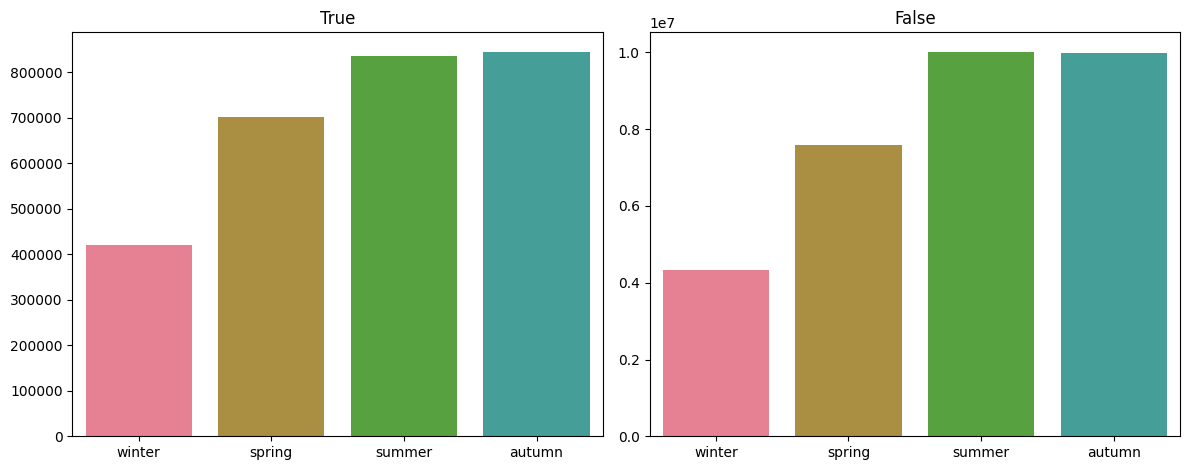

In [ ]:
fig , [ax1 , ax2] = plt.subplots(nrows = 1 , ncols = 2)

sns.barplot({'winter' : len(Twinter) , 'spring' : len(Tspring) , 'summer' : len(Tsummer) , 'autumn' : len(Tautumn)} , ax = ax1 , palette = sns.husl_palette())
sns.barplot({'winter' : len(Fwinter) , 'spring' : len(Fspring) , 'summer' : len(Fsummer) , 'autumn' : len(Fautumn)} , ax = ax2 , palette = sns.husl_palette())

fig.set_figwidth(12)
ax1.set_title('True')
ax2.set_title('False')

clear_output()
plt.tight_layout()
plt.show()

second assumption, its possible that our customer look for a hotel in middle of the night very desperately so there is higher chance that our customer book one our hotel in that time.we'll suggest a hypothesis that `True` values will be higher than `False` values in the night time and we're gonna check if that's true. so we use `time_sep` to take out time and separate it to 6 hour parts. as we can see in the result despite what we thought people tend to book our hotels in 6AM to 6PM range. and there isnt much difference between our two plots and it shows us what we guesses was totally wrong because ratio of people that book a hotel have the (kinda) same ratio as people that dont book a hotel so this column doesnt give us any good info so we'll drop it

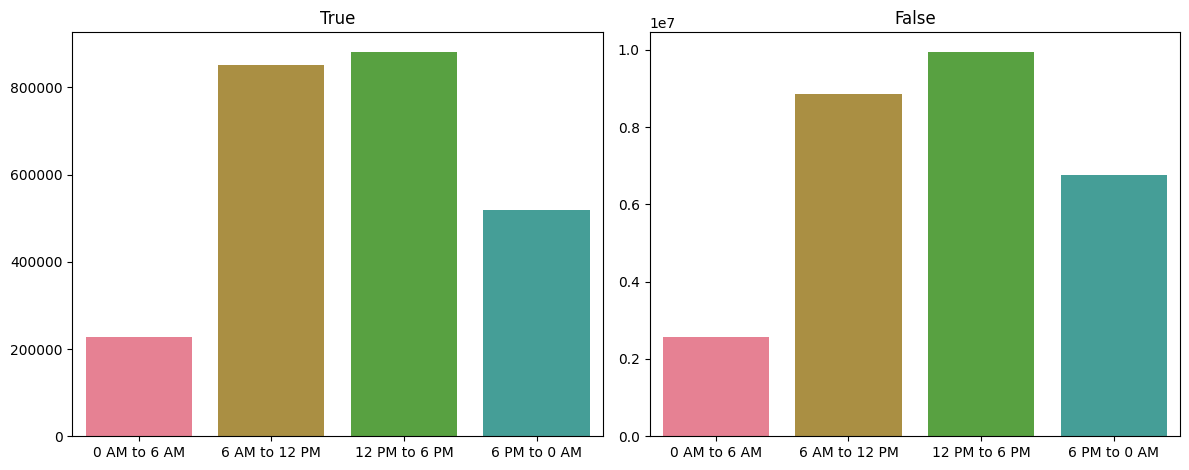

In [12]:
# so search_date is useless too
true_val = original_ds.query('is_booking == 1')
false_val = original_ds.query('is_booking == 0')

t_one , t_two , t_three , t_four = time_sep(true_val , 'search_date')
f_one , f_two , f_three , f_four = time_sep(false_val , 'search_date')

clear_output()

fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

sns.barplot({'0 AM to 6 AM' : len(t_one) , '6 AM to 12 PM' : len(t_two) , '12 PM to 6 PM' : len(t_three) , '6 PM to 0 AM' : len(t_four)} , ax = ax1 , palette = sns.husl_palette())
sns.barplot({'0 AM to 6 AM' : len(f_one) , '6 AM to 12 PM' : len(f_two) , '12 PM to 6 PM' : len(f_three) , '6 PM to 0 AM' : len(f_four)} , ax = ax2 , palette = sns.husl_palette())

fig.set_figwidth(12)
ax1.set_title('True')
ax2.set_title('False')

clear_output()
plt.tight_layout()
plt.show()

lets check `channel`. we need to find the outliers in this column so we'll plot a boxplot for it and it seems `c4` , `c6` , `c7` , `c8` , `c10` are outliers so we'll drop'em. those percentages are percentage of people that booked a hotel in whole dataset devided in channels. if we see a significant jump in a percentage this shows us this channel has good amount of influence in people to book a hotel. but we dont see that jump in channel. we have 20mil rows with `c9` as their channel and after that around 5mil with `c0`. its not that bad so i dont see any reason to drop this column and any reason to keep yet. maybe we'll get better insight in future so we'll keep it

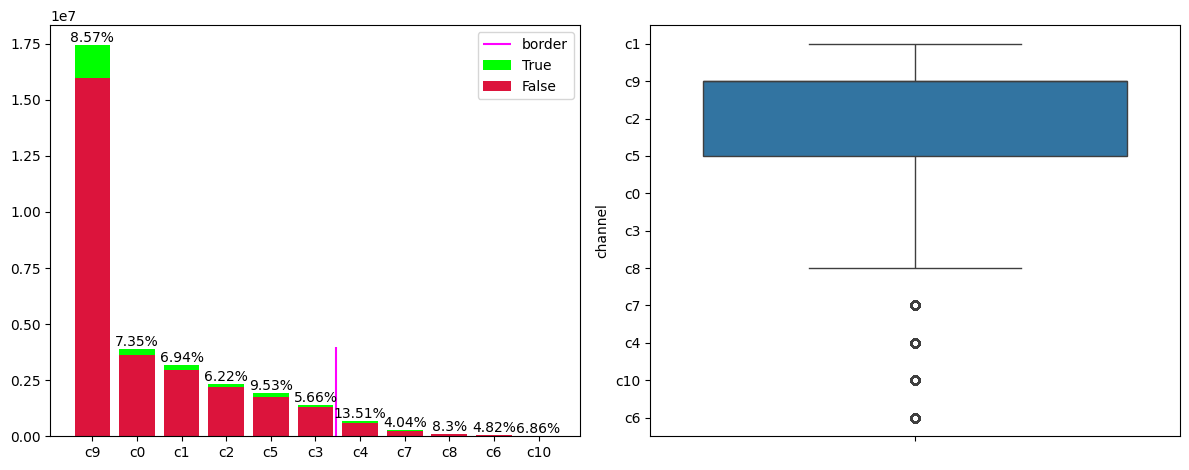

In [76]:
# and we'll consider c8 c7 c6 c10 as outliers
channel_count = original_ds.channel.value_counts()
grouped_channel = original_ds[['channel' , 'is_booking']].groupby(by = 'is_booking')
False_from_channel = grouped_channel.value_counts().loc[False]
True_from_channel = grouped_channel.value_counts().loc[True]
percentage_true = round(((True_from_channel / channel_count) * 100).loc[channel_count.index] , 2).astype(str) + '%' # this loc is for making the order correct



fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

plot_out = ax1.bar(x = channel_count.index , height = channel_count.values  , color = 'lime')
ax1.bar(x = False_from_channel.index , height = False_from_channel.values , color = 'crimson')
ax1.vlines(x = 5.45 , ymin = 0 , ymax = 0.4e7 , color = 'magenta')
sns.boxplot(original_ds.channel , ax = ax2)

ax1.legend(labels = ['border' , 'True' , 'False'])
ax1.bar_label(plot_out , percentage_true)

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

**you might say merge c0 , c1 and other values together so they make a single column which is aligned to c9. in general i applied value merge in different columns and it didnt affect test results so i didnt apply it here for any columns**

8.4% of people that didnt check our site with a mobile booked a hotel but only approx 5.9 of people that checked our site with a mobile booked a hotel. again, not a significant jump and again i didnt find any reason to drop nor keep it yet so we'll just keep it for further investigation.

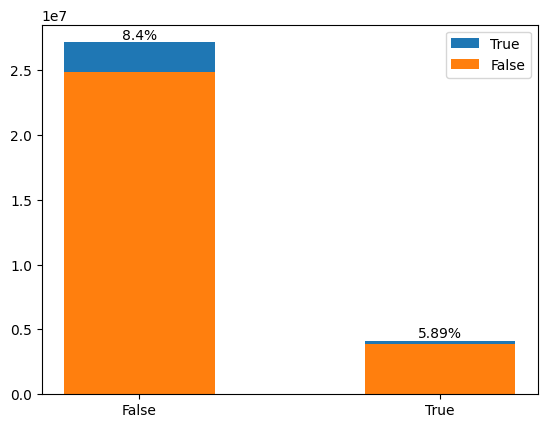

In [13]:
package_counts = original_ds.is_mobile.value_counts()
grouped_mobile = original_ds[['is_booking' , 'is_mobile']].groupby(by = 'is_booking').value_counts()
true_mobile = grouped_mobile.loc[True]
false_package = grouped_mobile.loc[False]
package_percentage = (round((true_mobile / package_counts) * 100 , 2)).astype(str) + '%'

container = plt.bar(x = package_counts.index.astype(str) , height = package_counts.values , width = 0.5)
plt.bar(x = false_package.index , height = false_package.values , width = 0.5)
plt.bar_label(container = container , labels = package_percentage)

plt.legend(['True' , 'False'])
plt.show()

its kinda weird but 9.25% of people that didnt check tour or etc booked a hotel and only 4.52% of people who checked booked a hotel. its about 2 times diff. kinda significant to me. so we'll keep it.

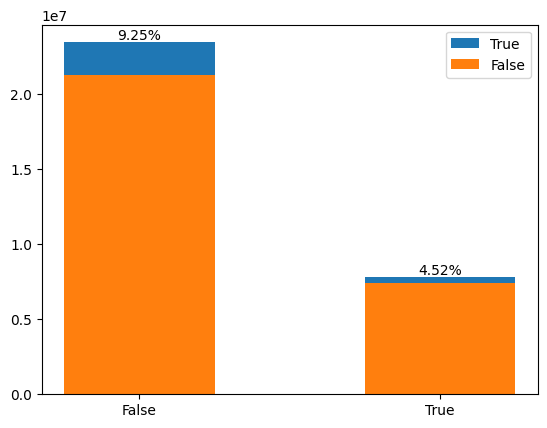

In [14]:
package_counts = original_ds.is_package.value_counts()
grouped_mobile = original_ds[['is_booking' , 'is_package']].groupby(by = 'is_booking').value_counts()
true_package = grouped_mobile.loc[True]
false_package = grouped_mobile.loc[False]
package_percentage = (round((true_package / package_counts) * 100 , 2)).astype(str) + '%'

container = plt.bar(x = package_counts.index.astype(str) , height = package_counts.values , width = 0.5)
plt.bar(x = false_package.index , height = false_package.values , width = 0.5)
plt.bar_label(container = container , labels = package_percentage)

plt.legend(['True' , 'False'])
plt.show()

as we can see from 300 onwards values become similar and kinda same and it important to note that we have approx 50000 unique values in `destination` so it means that from 300 to 50000 we have similar values and this from 50 to 50000 make up to 22mil rows of our data so we can just clean it. i conclude that this column dont give us information we need for training so we'll just drop it

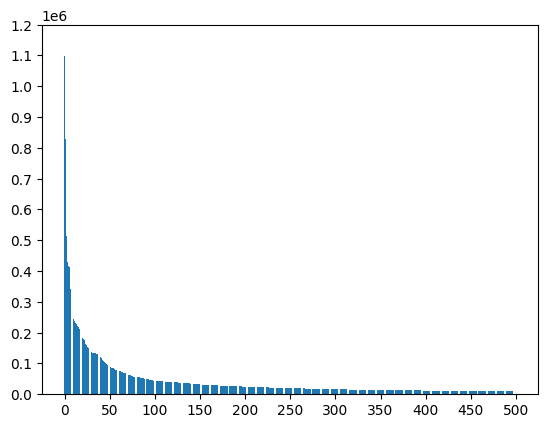

In [15]:
# we can conclude that destination column is useless cuz unique destinations are about 50000
plt.bar(height = original_ds.destination.value_counts().values[:500] , x = range(500))
plt.xticks(range(0,501,50))
plt.yticks(range(0,1250000,100000))
plt.show()

in `n_adults` column boxplot we see what we see so i chose to use z-score as outlier detection instead of boxplot. any values outside of upper bound and lower bound in left plot will be considered an outlier. but i'll drop "0" too despite being inside the bound because it has such a low value. again we see a kinda significant jump in "1" so we'll just keep it for further investigation.

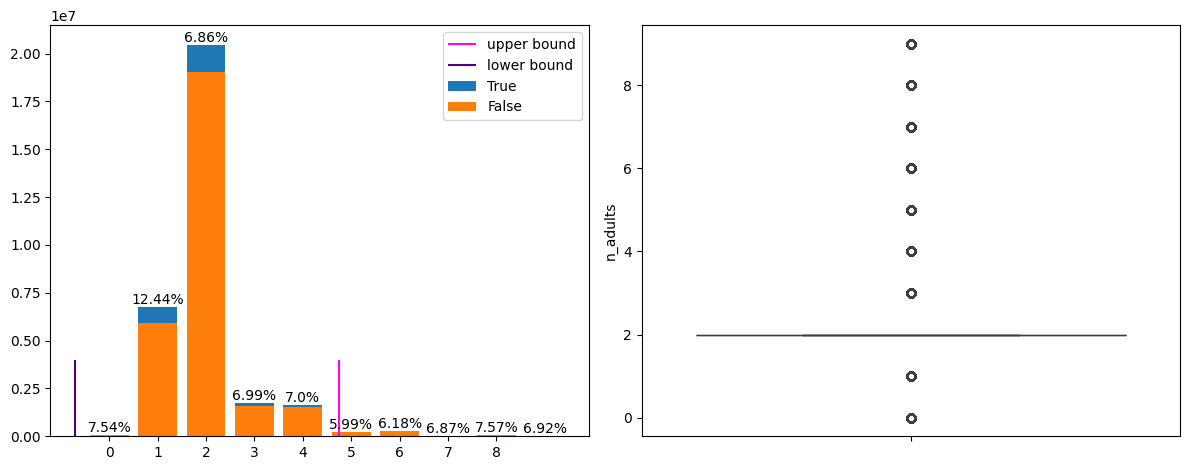

In [16]:
adults_count = original_ds.n_adults.value_counts()
grouped_adults = original_ds[['is_booking' , 'n_adults']].groupby(by = 'is_booking').value_counts()
true_adults = grouped_adults.loc[True]
false_adults = grouped_adults.loc[False]
true_adults_percentage = round(((true_adults / adults_count) * 100).loc[adults_count.index] , 2).astype(str) + '%'
fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

container = ax1.bar(x = adults_count.index , height = adults_count.values)
ax1.bar(x = false_adults.index , height = false_adults.values)
ax1.vlines(x = 4.75 , ymin = 0 , ymax = 0.4e7 , color = 'magenta' )
ax1.vlines(x = -0.71 , ymin = 0 , ymax = 0.4e7 , color = 'indigo' )
ax1.set_xticks(range(0 , 9 ,1))
ax1.bar_label(container = container , labels = true_adults_percentage)
ax1.legend(['upper bound' , 'lower bound' , 'True' , 'False'])

sns.boxplot(original_ds.n_adults , ax = ax2)

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [8]:
# this is even better than n_children cuz it has more spread so we'll keep 1 2 3 4
print('std: ' , original_ds.n_adults.std())
print('mean: ' , original_ds.n_adults.mean())
print('z-score uppper bound: ', original_ds.n_adults.mean() + (3 * original_ds.n_adults.std()))
print('z-score lower bound: ', original_ds.n_adults.mean() - (3 * original_ds.n_adults.std()))
adults_count

std:  0.9105342507887598
mean:  2.020772864806528
z-score uppper bound:  4.752375617172808
z-score lower bound:  -0.7108298875597514


n_adults
2    20461652
1     6749905
3     1719713
4     1645766
6      276519
5      233749
8       71530
0       60410
7       36757
9       12676
Name: count, dtype: int64

just like `n_adults` we'll use z-score. but we dont see a significant jump so we dont any reason to drop it so we'll keep it for further investigation

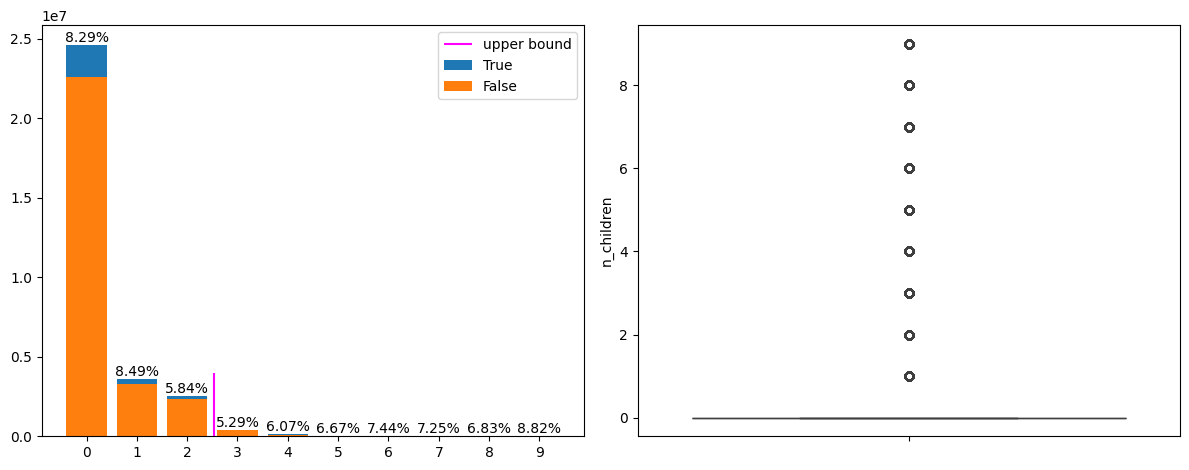

In [18]:
kids_count = original_ds.n_children.value_counts()
grouped_kids = original_ds[['is_booking' , 'n_children']].groupby(by = 'is_booking').value_counts()
true_kids = grouped_kids.loc[True]
false_kids = grouped_kids.loc[False]
true_kids_percentage = round(((true_kids / kids_count) * 100).loc[kids_count.index] , 2).astype(str) + '%'
fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

container = ax1.bar(x = kids_count.index , height = kids_count.values)
ax1.bar(x = false_kids.index , height = false_kids.values)
ax1.vlines(x = 2.53 , ymin = 0 , ymax = 0.4e7 , color = 'magenta' )
ax1.set_xticks(range(0 , 10 ,1))
ax1.bar_label(container = container , labels = true_kids_percentage)
ax1.legend(['upper bound' , 'True' , 'False'])

sns.boxplot(original_ds.n_children , ax = ax2)

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [11]:
# this column will be candidate for drop but its not that bad ill keep it and ill build another model without it to see the diff it makes
# we'll keep rows with 0 1 2
print('std: ' , original_ds.n_children.std())
print('mean: ' , original_ds.n_children.mean())
print('z-score upper bound: ', original_ds.n_children.mean() + (3 * original_ds.n_children.std()))
print('z-score lower bound: ', original_ds.n_children.mean() - (3 * original_ds.n_children.std()))
kids_count

std:  0.731954055727614
mean:  0.3351646761390001
z-score upper bound:  2.531026843321842
z-score lower bound:  -1.8606974910438416


n_children
0    24610046
1     3601039
2     2501887
3      407115
4      115268
5       15544
6       12726
7        2315
8        1988
9         749
Name: count, dtype: int64

again, we use z-score and we see a 27.73% percent in `0` values which is inside our range! but no its number of occurrence is so insignificant that we'll have to drop that too. and we dont see any jump beside that and there is huge difference between `1` and `2` so it just make out work difficult

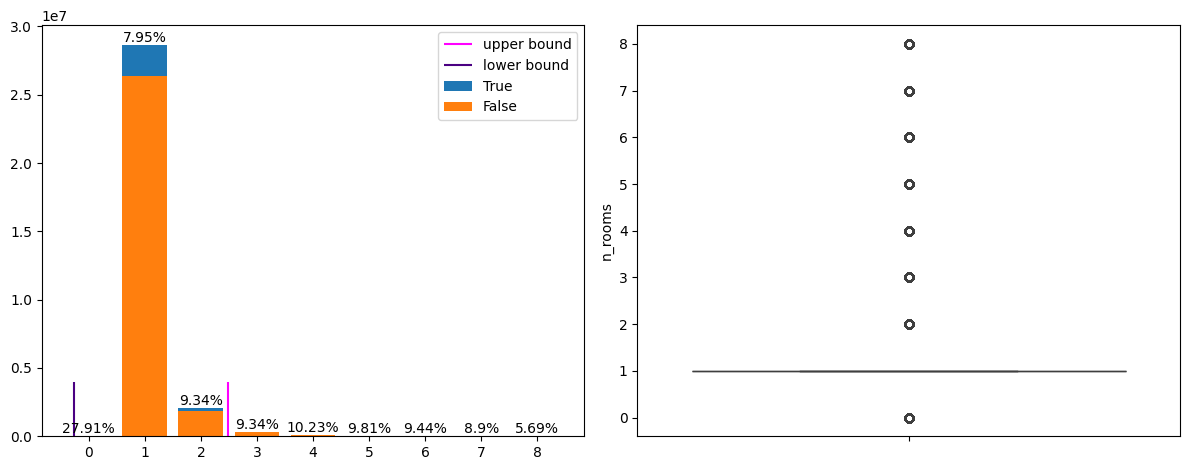

In [20]:
rooms_count = original_ds.n_rooms.value_counts()
grouped_rooms = original_ds[['is_booking' , 'n_rooms']].groupby(by = 'is_booking').value_counts()
true_rooms = grouped_rooms.loc[True]
false_rooms = grouped_rooms.loc[False]
true_rooms_percentage = round(((true_rooms / rooms_count) * 100).loc[rooms_count.index] , 2).astype(str) + '%'

fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

container = ax1.bar(x = rooms_count.index , height = rooms_count.values)
ax1.bar(x = false_rooms.index , height = false_rooms.values)
ax1.vlines(x = 2.49 , ymin = 0 , ymax = 0.4e7 , color = 'magenta' )
ax1.vlines(x = -0.26 , ymin = 0 , ymax = 0.4e7 , color = 'indigo' )
ax1.set_xticks(range(0 , 9 ,1))
ax1.bar_label(container = container , labels = true_rooms_percentage)
ax1.legend(['upper bound' , 'lower bound' , 'True' , 'False'])

sns.boxplot(original_ds.n_rooms , ax = ax2)

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [13]:
# we conclude that this info is useless
# with z score method for outlier detection we can use 0 1 2 and delete the rest but with 31 mil "1" and 2mil "2" and 815 "0"
# we see that if these numbers dont complicate things for model to learn, it very unbalanced and doesnt add anything
print('std: ' , original_ds.n_rooms.std())
print('mean: ' , original_ds.n_rooms.mean())
print('z-score upper bound: ', original_ds.n_rooms.mean() + 3 * original_ds.n_rooms.std())
print('z-score lower bound: ', original_ds.n_rooms.mean() - 3 * original_ds.n_rooms.std())
rooms_count

std:  0.45931760306991654
mean:  1.1130395443337753
z-score upper bound:  2.4909923535435246
z-score lower bound:  -0.2649132648759742


n_rooms
1    28657093
2     2079232
3      348903
4       88777
5       38714
8       25304
6       19486
7       10426
0         742
Name: count, dtype: int64

this plot doesnt give us any useful information. so i dont see any reason to drop or keep it so ill keep it for further investigation

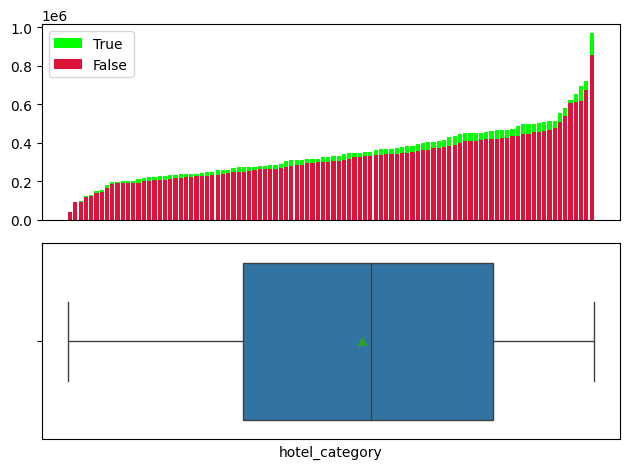

In [158]:
hotel_cat_groupby_booking = original_ds.groupby(by = 'is_booking')['hotel_category'].value_counts()
hotel_cat_counts = original_ds.hotel_category.value_counts().values
labels = original_ds.hotel_category.value_counts().index
F_hotel_cat = hotel_cat_groupby_booking.loc[False].values
T_hotel_cat = hotel_cat_groupby_booking.loc[True].values

F_hotel_cat.sort()
T_hotel_cat.sort()
hotel_cat_counts.sort()


fig , [ax1 , ax2] = plt.subplots(nrows = 2 , ncols = 1)

ax1.bar(height = hotel_cat_counts , x = labels , linewidth = 0 , color = 'lime')
ax1.bar(height = F_hotel_cat , x = labels , linewidth = 0 , color = 'crimson')
ax1.tick_params(bottom = False , labelbottom = False)
ax1.legend(['True' , 'False'])

# the boxplot is for whole data
sns.boxplot(x = original_ds.hotel_category , vert = False , showmeans = True , ax = ax2)
ax2.tick_params(bottom = False , labelbottom = False)
ax2.invert_xaxis()

fig.tight_layout()
plt.show()

with IQR we'll find outliers in our new column

In [22]:
valid_diff_date = original_ds.query('diff_date > 0')['diff_date']
upper_cap = valid_diff_date.quantile(.75) + (1.5 * (valid_diff_date.quantile(.75) - (valid_diff_date.quantile(.25))))
print("diff_date upper cap: " , upper_cap)
print('any value bigger than this is a outlier')

diff_date upper cap:  8.5
any value bigger than this is a outlier


and we can see people tend to stay in hotels for couple of days the more we increase days less people will book a hotel. plot look promising we'll keep it

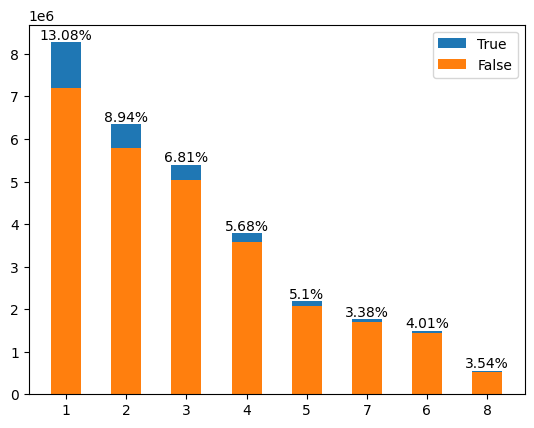

In [23]:
outlier_free_diff_date = original_ds.query('0 < diff_date < 8.5')['diff_date'].value_counts()
grouped_outlier_free_diff_date = original_ds.query('0 < diff_date < 8.5')[['diff_date' , 'is_booking']].groupby(by = 'is_booking').value_counts()
true_diff_date = grouped_outlier_free_diff_date.loc[True]
false_diff_date = grouped_outlier_free_diff_date.loc[False]
diff_date_percentage = round(((true_diff_date / outlier_free_diff_date) * 100).loc[outlier_free_diff_date.index] , 2).astype(str) + '%' 

container = plt.bar(x = outlier_free_diff_date.index.astype(str) , height = outlier_free_diff_date.values , width = 0.5)
plt.bar(x = false_diff_date.index.astype(str) , height = false_diff_date.values , width = 0.5)
plt.bar_label(container = container , labels = diff_date_percentage)

plt.legend(['True' , 'False'])
plt.show()

and now we'll drop our useless columns and outliers. and turn our categorical values into something that computer understands and turn their dtype into `int8` so it occupies less space

In [14]:
# now we pop useless columns
dropped_ds = original_ds.drop(['user' , 'search_date' , 'destination' , 'checkIn_date' , 'checkOut_date' , 'n_rooms'] , axis = 1)
dropped_test = test.drop(['user' , 'search_date' , 'destination' , 'checkIn_date' , 'checkOut_date' , 'n_rooms'] , axis = 1)


# negative value for diff_date is unreasonable and i checked their site you cant search for a hotel where checkIn and checkOut is the same date
# so diff_value must be higher than 0
cleaned_ds = dropped_ds.query('channel not in ["c4" , "c8" , "c7" , "c6" , "c10"] & n_children in [0 , 1 , 2] & n_adults in [1 , 2 , 3 , 4] & 0 < diff_date < 8.5')
cleaned_test = dropped_test.query('channel not in ["c4" , "c8" , "c7" , "c6" , "c10"] & n_children in [0 , 1 , 2] & n_adults in [1 , 2 , 3 , 4] & 0 < diff_date < 8.5')

In [104]:
# now we make True False to 1 0
cleaned_ds['is_mobile'] = bool_to_binary(ds = cleaned_ds , column = 'is_mobile')
cleaned_ds['is_package'] = bool_to_binary(ds = cleaned_ds , column = 'is_package')
cleaned_ds['is_booking'] = bool_to_binary(ds = cleaned_ds , column = 'is_booking')
clear_output()

In [15]:
# and we use astype to down cast dtype to int8 which it takes us less space
cleaned_ds['channel'] = cleaned_ds['channel'].str[1:].astype('Int8')
cleaned_ds['hotel_category'] = cleaned_ds['hotel_category'].str[1:].astype('Int8')
cleaned_ds['n_adults'] = cleaned_ds['n_adults'].astype('Int8')
cleaned_ds['n_children'] = cleaned_ds['n_children'].astype('Int8')
cleaned_ds['diff_date'] = cleaned_ds['diff_date'].astype('Int8')
clear_output()

In [2]:
# with open('cleaned_ds.pkl' , 'wb') as pickle_out:
#     pickle.dump(cleaned_ds , pickle_out)
#     pickle_out.close()

# with open('cleaned_test.pkl' , 'wb') as pickle_out:
#     pickle.dump(cleaned_test , pickle_out)
#     pickle_out.close()

with open('cleaned_ds.pkl' , 'rb') as pickle_in:
    cleaned_ds = pickle.load(pickle_in)
    pickle_in.close()

with open('cleaned_test.pkl' , 'rb') as pickle_in:
    cleaned_test = pickle.load(pickle_in)
    pickle_in.close()

its good that 34 mil worth of data only uses 566mb

In [15]:
cleaned_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28290794 entries, 4530150 to 31331092
Data columns (total 8 columns):
 #   Column          Dtype
---  ------          -----
 0   channel         Int8 
 1   is_mobile       int8 
 2   is_package      int8 
 3   n_adults        Int8 
 4   n_children      Int8 
 5   hotel_category  Int8 
 6   is_booking      int8 
 7   diff_date       Int8 
dtypes: Int8(5), int8(3)
memory usage: 566.6 MB


# Imbalanced data
***

as we can see in `is_mobile` , `is_package` , `n_children` and `is_booking` 75% of our values are "0" and this tell us these columns dont give us much info for training but `is_booking` is our target! we cant drop that and as we can see in pie chart our data is so imbalanced. only 8.46% of our data is `True` and 91.54% is `False` so we have to find some way to fix this somehow.

In [16]:
cleaned_ds.describe()

,channel,is_mobile,is_package,n_adults,n_children,hotel_category,is_booking,diff_date
count,28290794.0,2.829079e+07,2.829079e+07,28290794.0,28290794.0,28290794.0,2.829079e+07,28290794.0
mean,5.888763,1.322390e-01,2.357657e-01,1.938209,0.279133,49.698038,8.457447e-02,2.975752
std,3.738021,3.387504e-01,4.244765e-01,0.69923,0.602744,28.97372,2.782474e-01,1.894687
min,0.0,0.000000e+00,0.000000e+00,1.0,0.0,0.0,0.000000e+00,1.0
25%,2.0,0.000000e+00,0.000000e+00,2.0,0.0,25.0,0.000000e+00,1.0
50%,9.0,0.000000e+00,0.000000e+00,2.0,0.0,49.0,0.000000e+00,3.0
75%,9.0,0.000000e+00,0.000000e+00,2.0,0.0,73.0,0.000000e+00,4.0
max,9.0,1.000000e+00,1.000000e+00,4.0,2.0,99.0,1.000000e+00,8.0


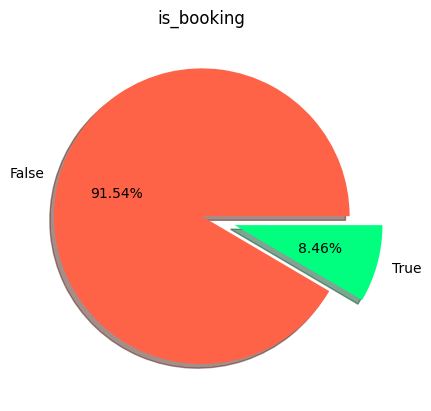

In [17]:
explode = (0, 0.23)
plt.pie(cleaned_ds['is_booking'].value_counts() , labels = ['False' , 'True'] , autopct = '%1.2f%%' , explode = explode , shadow = True , colors = ['tomato' , 'springgreen'])
plt.title('is_booking')
plt.show()

at first we need to check if we need to do anything on dataset or our model fit on data well. so we will call `cal_score` function on our imbalanced dataset to see how it will perform. we will load the model i trained on imbalanced data during analyzing and find the best threshold and apply it. but we need to find the columns to fit on so we plot pairplot. as we can see `hotel_category` is not a good column and we will see that `channel` is not a good columns too so we'll drop it too

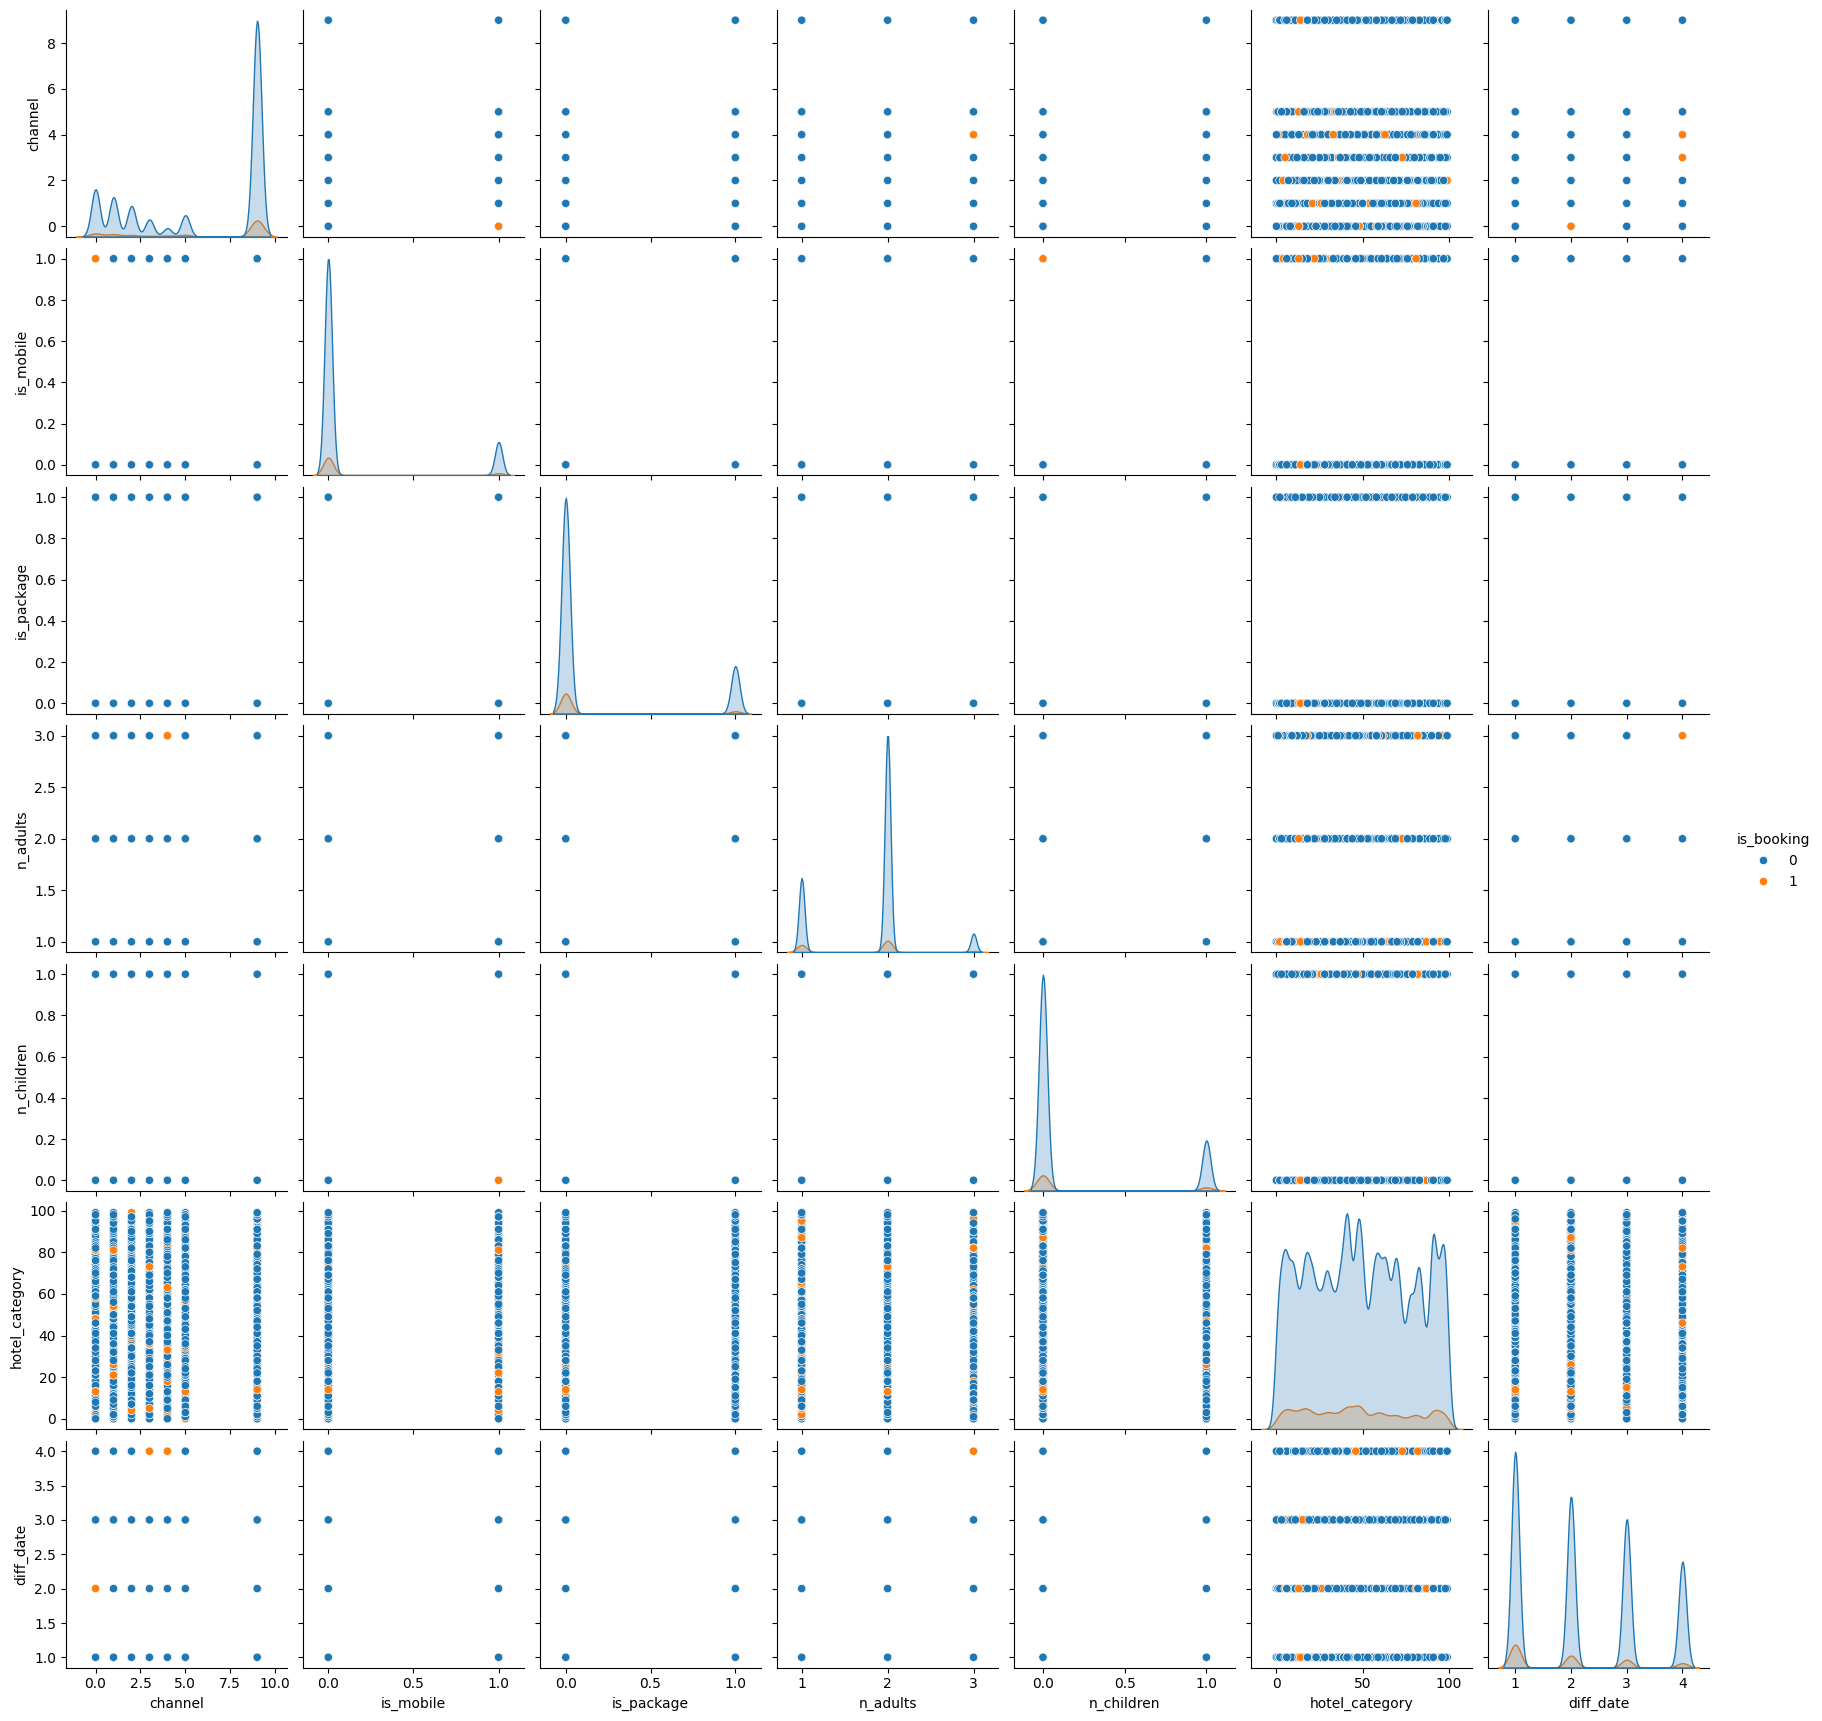

In [78]:
sns.pairplot(cleaned_ds.sample(n = 1000000) , hue = 'is_booking')

while analyzing i built a model on imbalanced data and saved it. i use that model for finding best threshold for imbalanced data and use that threshold in `cal_score`

In [15]:
model_check = keras.models.load_model('imbal_model.h5')

Tcheck = cleaned_test.drop(['hotel_category' , 'channel' , 'n_adults'] , axis = 1)
Tcheck['is_mobile'] = bool_to_binary(ds = Tcheck , column = 'is_mobile')
Tcheck['is_package'] = bool_to_binary(ds = Tcheck , column = 'is_package')
Tcheck['is_booking'] = bool_to_binary(ds = Tcheck , column = 'is_booking')

x_check = Tcheck.drop(['is_booking'] , axis = 1)
y_check = Tcheck['is_booking']

x_check = np.asarray(x_check , dtype = 'float32')
y_check = np.asarray(y_check , dtype = 'float32')

prediction = model_check.predict(x_check[ :500000])

preci , reca , thresh = precision_recall_curve(y_check[ :500000] , prediction)
fscore = (2 * preci * reca) / (preci + reca)
ix = np.nanargmax(fscore)

TheThreshold2 = thresh[ix]
clear_output()
print(TheThreshold2)

0.1149372


this looks bad. real bad.

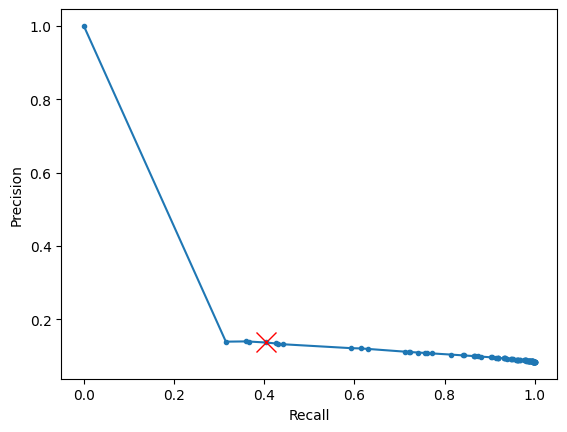

In [19]:
plt.plot(reca , preci , marker = '.')
plt.plot(reca[ix] , preci[ix] , 'rx' , markersize = 15)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [18]:
scores = pd.DataFrame(columns = ['precision' , 'recall' , 'f1 score' , 'confusion_matrix' , 'accuracy' , 'roc auc score' , 'Class 0 accuracy' , 'Class 1 accuracy' , 'average accuracy'])
imbalanced_Scores = cal_score(scores , Columns_to_drop , Threshold = TheThreshold2 , train = cleaned_ds , test = cleaned_test)
clear_output()

and we get average accuracy of 58.72% at best. we need to check if we can get any better results with different way

In [ ]:
imbalanced_Scores

,precision,recall,f1 score,confusion_matrix,accuracy,roc auc score,Class 0 accuracy,Class 1 accuracy,average accuracy
"['is_mobile', 'is_booking']",0.000000,0.000000,0.000000,"[[457976, 0], [42024, 0]]",0.915952,0.519343,0.000000,100.000000,50.000000
"['is_package', 'is_booking']",0.000000,0.000000,0.000000,"[[457976, 0], [42024, 0]]",0.915952,0.554707,0.000000,100.000000,50.000000
"['n_children', 'is_booking']",0.000000,0.000000,0.000000,"[[457976, 0], [42024, 0]]",0.915952,0.513897,0.000000,100.000000,50.000000
"['is_booking', 'diff_date']",0.131768,0.439701,0.202771,"[[336223, 121753], [23546, 18478]]",0.709402,0.621865,43.970112,73.414982,58.692547
"['is_mobile', 'is_package', 'is_booking']",0.000000,0.000000,0.000000,"[[457976, 0], [42024, 0]]",0.915952,0.564817,0.000000,100.000000,50.000000
"['is_mobile', 'n_children', 'is_booking']",0.000000,0.000000,0.000000,"[[457976, 0], [42024, 0]]",0.915952,0.530113,0.000000,100.000000,50.000000
"['is_mobile', 'is_booking', 'diff_date']",0.134818,0.392585,0.200710,"[[352102, 105874], [25526, 16498]]",0.737200,0.626635,39.258519,76.882195,58.070357
"['is_package', 'n_children', 'is_booking']",0.000000,0.000000,0.000000,"[[457976, 0], [42024, 0]]",0.915952,0.563617,0.000000,100.000000,50.000000
"['is_package', 'is_booking', 'diff_date']",0.134398,0.427327,0.204484,"[[342316, 115660], [24066, 17958]]",0.720548,0.627024,42.732724,74.745402,58.739063
"['n_children', 'is_booking', 'diff_date']",0.134307,0.415191,0.202960,"[[345513, 112463], [24576, 17448]]",0.725922,0.624127,41.519132,75.443473,58.481302


one way is resampling. we have upsample and undersample. in upsample we resample minority so it will have same amount of majority. in undersample we will resample majority class down to amount of minority. in undersampling we will lose data but in upsampling it will cost our memory and space. i have the memory and space so i will use upsample instead of undersample. but lets check our correlations first to see if we see any pattern.

In [106]:
correlations = cleaned_ds.corr()
correlations

,channel,is_mobile,is_package,n_adults,n_children,hotel_category,is_booking,diff_date
channel,1.000000,-0.033784,-0.011352,-0.035890,0.006941,-0.000056,0.027908,-0.020702
is_mobile,-0.033784,1.000000,0.056853,0.033931,0.020055,0.008822,-0.031386,0.022645
is_package,-0.011352,0.056853,1.000000,0.005471,-0.033386,0.037618,-0.073345,0.389216
n_adults,-0.035890,0.033931,0.005471,1.000000,0.091314,0.015675,-0.061313,0.051342
n_children,0.006941,0.020055,-0.033386,0.091314,1.000000,0.013009,-0.019976,0.049813
hotel_category,-0.000056,0.008822,0.037618,0.015675,0.013009,1.000000,-0.021342,0.053650
is_booking,0.027908,-0.031386,-0.073345,-0.061313,-0.019976,-0.021342,1.000000,-0.112429
diff_date,-0.020702,0.022645,0.389216,0.051342,0.049813,0.053650,-0.112429,1.000000


and these correlations are so disappointing and if we train on this we abslutely get nothing good

<Axes: >

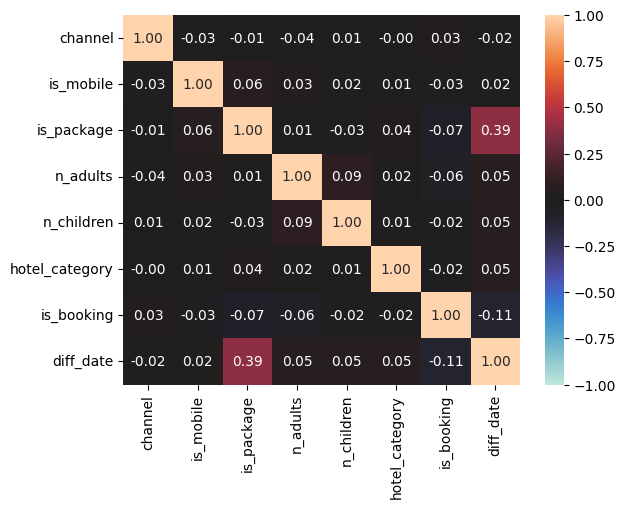

In [107]:
sns.heatmap(correlations , annot = True , vmin = -1 , fmt = ".2f" , center = 0)

we know pairwise correlation may not be enough so we will calculate VIF too but its good to know that for decision tree and tree based models this info wont help us but in regression and mse and ... will helps us. any vif more than 5 or 7.5 is bad and we should delete it. as we can see all is good here

In [44]:
exo = cleaned_ds.drop(axis = 1 , columns = 'is_booking')
cols = exo.columns
VIF_vals = [VIF(exog = np.asarray(exo.values , dtype = 'float64') , exog_idx = i) for i in range(len(cols))]
vif = pd.DataFrame({'columns' : cols , 'imbalanced VIF' : VIF_vals})
vif

,columns,imbalanced VIF
0,channel,2.869484
1,is_mobile,1.152183
2,is_package,1.552567
3,n_adults,4.863814
4,n_children,1.231012
5,hotel_category,3.338707
6,diff_date,3.713270


# resampled data
***

one way as i told is repeat some rows (upsampling) and concatenate it to our dataframe so we achieve a more balanced dataframe f.e if we have 100 datapoints which we have 10 zeros and 90 ones so we repeat 0 as much as we get 80 zeros out of it and after we concatenate it we have 90 ones and 90 zeros. our ratio is 91.54% false and 8.46% true for our target column so we need to repeat rows with true value as their `is_booking` column. `is_mobile` , `is_package` , `n_children` 0.75 quantiles are 0 so their columns specify as useless but we can fix this along the way we fix `is_booking`. we can repeat **1** for `is_mobile` and `is_package` and (**0** , **1**) for `n_children`. so we need to repeat rows with **1** as their `is_mobile` and `is_package` columns and (**0** , **1**) as their `n_children` column and **1** as our target column at the same time. so we'll get our rows with mentioned values to repeat'em

In [28]:
specific_rows = cleaned_ds.query('is_mobile == 1 and is_package == 1 and is_booking == 1 and (n_children == 1 or n_children == 2)')
print(specific_rows.n_children.value_counts())

n_children
1    2528
2    1667
Name: count, dtype: Int64


we know that n_children has 2 possible values (1 , 2). and they and diff values ('2' have less quantity than '1') so if we resample them they will have different impact so we need to make them have an equal impact. at first we separate all rows with n_chilren = 1 and all rows with n_chilren = 2. we resample 2 that have same imapct as 1 does and we concatenate resampled rows with rows with n_children == 1. after these steps we resample the obtained dataframe with our cleaned_ds so we can have a more balanced dataset

In [ ]:
major_E = specific_rows.query('n_children == 1')
minor_E = specific_rows.query('n_children == 2')

resampled_minority = resample(minor_E , replace = True , n_samples = len(major_E)) # resample so n_children values are aligned
better_specific_rows = pd.concat([major_E , resampled_minority])

resampled_rows = resample(better_specific_rows , replace = True , n_samples = int(24e6)) # now final resample
better_ds = pd.concat([cleaned_ds , resampled_rows])

and now we can see the impact of our doing on our dataset

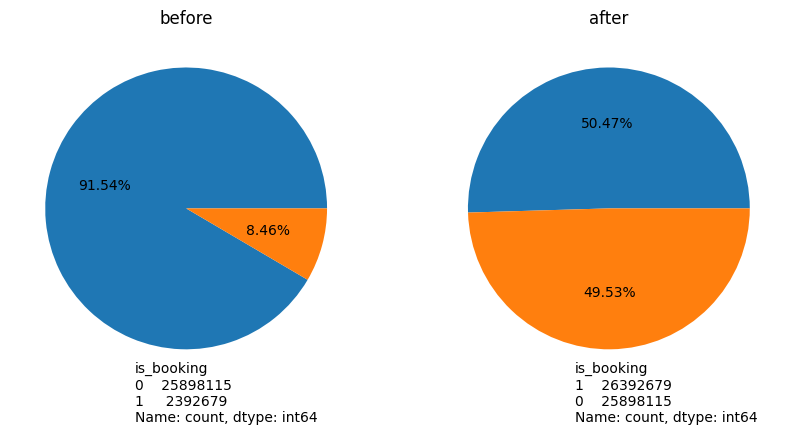

In [32]:
fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

ax1.pie(cleaned_ds.is_booking.value_counts() , autopct = '%1.2f%%')
ax1.set_title('before')

ax2.pie(better_ds.is_booking.value_counts() , autopct = '%1.2f%%')
ax2.set_title('after')

plt.figtext(0.25 , 0.05 , cleaned_ds.is_booking.value_counts())
plt.figtext(0.69 , 0.05 , better_ds.is_booking.value_counts())
fig.set_figwidth(10)
plt.show()

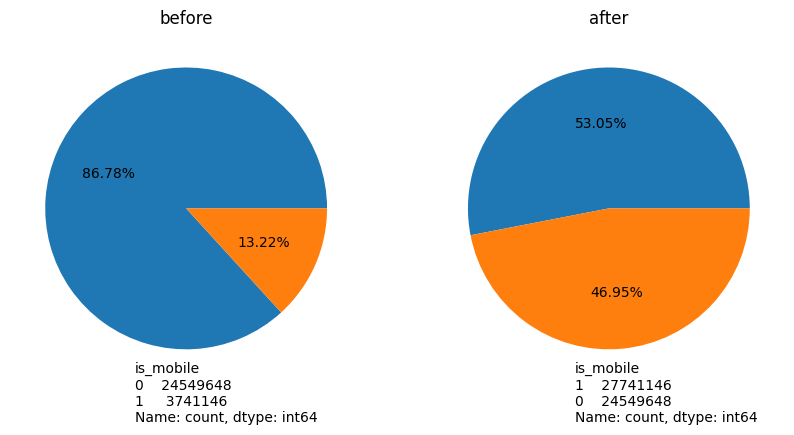

In [33]:
fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

ax1.pie(cleaned_ds.is_mobile.value_counts() , autopct = '%1.2f%%')
ax1.set_title('before')

ax2.pie(better_ds.is_mobile.value_counts() , autopct = '%1.2f%%')
ax2.set_title('after')

plt.figtext(0.25 , 0.05 , cleaned_ds.is_mobile.value_counts())
plt.figtext(0.69 , 0.05 , better_ds.is_mobile.value_counts())
fig.set_figwidth(10)
plt.show()

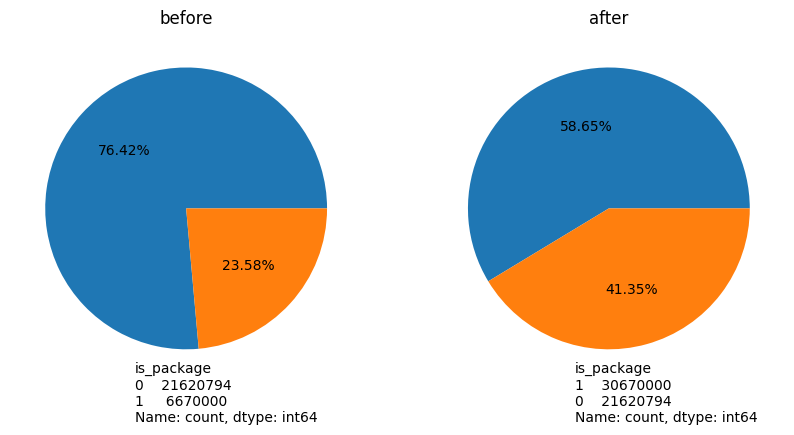

In [34]:
fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

ax1.pie(cleaned_ds.is_package.value_counts() , autopct = '%1.2f%%')
ax1.set_title('before')

ax2.pie(better_ds.is_package.value_counts() , autopct = '%1.2f%%')
ax2.set_title('after')

plt.figtext(0.25 , 0.05 , cleaned_ds.is_package.value_counts())
plt.figtext(0.69 , 0.05 , better_ds.is_package.value_counts())
fig.set_figwidth(10)
plt.show()

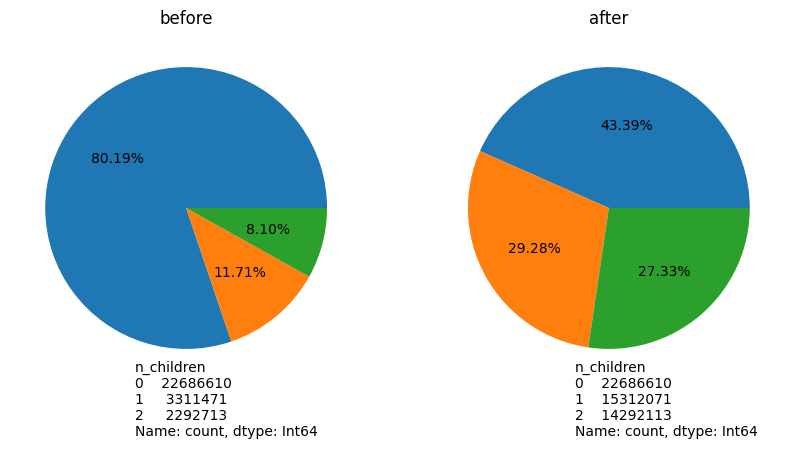

In [35]:
fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

ax1.pie(cleaned_ds.n_children.value_counts() , autopct = '%1.2f%%')
ax1.set_title('before')

ax2.pie(better_ds.n_children.value_counts() , autopct = '%1.2f%%')
ax2.set_title('after')

plt.figtext(0.25 , 0.02 , cleaned_ds.n_children.value_counts())
plt.figtext(0.69 , 0.02 , better_ds.n_children.value_counts())
fig.set_figwidth(10)
plt.show()

as we can see we fixed the columns we wanted to and other columns which we didnt want to change didnt change that much so its good to see

In [27]:
display(cleaned_ds.describe())
display(better_ds.describe())

,channel,is_mobile,is_package,n_adults,n_children,hotel_category,is_booking,diff_date
count,28290794.0,2.829079e+07,2.829079e+07,28290794.0,28290794.0,28290794.0,2.829079e+07,28290794.0
mean,5.888763,1.322390e-01,2.357657e-01,1.938209,0.279133,49.698038,8.457447e-02,2.975752
std,3.738021,3.387504e-01,4.244765e-01,0.69923,0.602744,28.97372,2.782474e-01,1.894687
min,0.0,0.000000e+00,0.000000e+00,1.0,0.0,0.0,0.000000e+00,1.0
25%,2.0,0.000000e+00,0.000000e+00,2.0,0.0,25.0,0.000000e+00,1.0
50%,9.0,0.000000e+00,0.000000e+00,2.0,0.0,49.0,0.000000e+00,3.0
75%,9.0,0.000000e+00,0.000000e+00,2.0,0.0,73.0,0.000000e+00,4.0
max,9.0,1.000000e+00,1.000000e+00,4.0,2.0,99.0,1.000000e+00,8.0


,channel,is_mobile,is_package,n_adults,n_children,hotel_category,is_booking,diff_date
count,52290794.0,5.229079e+07,5.229079e+07,52290794.0,52290794.0,52290794.0,5.229079e+07,52290794.0
mean,5.78963,5.305168e-01,5.865277e-01,1.96705,0.839532,51.189994,5.047290e-01,3.753031
std,3.847215,4.990679e-01,4.924560e-01,0.670171,0.825525,28.818752,4.999776e-01,2.0131
min,0.0,0.000000e+00,0.000000e+00,1.0,0.0,0.0,0.000000e+00,1.0
25%,1.0,0.000000e+00,0.000000e+00,2.0,0.0,26.0,0.000000e+00,2.0
50%,9.0,1.000000e+00,1.000000e+00,2.0,1.0,53.0,1.000000e+00,4.0
75%,9.0,1.000000e+00,1.000000e+00,2.0,2.0,73.0,1.000000e+00,5.0
max,9.0,1.000000e+00,1.000000e+00,4.0,2.0,99.0,1.000000e+00,8.0


at first we can see there are some improvements in correlations but its a mirage. before go any further lets define what is a good correlation. a good correlation according to geeksforgeeks is |0.6| < corr. there is no good correlation and if we train on this good looking correlations we wont get anything good out of it because all those columns that have good correlation with our target have good correlation with each other too. and this is not good.

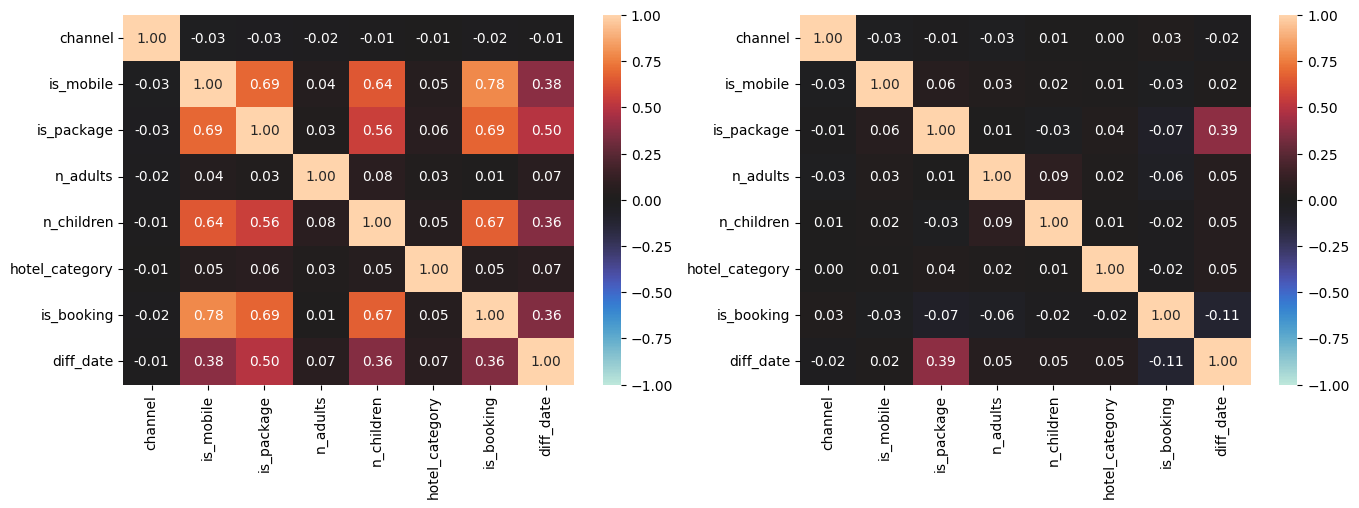

In [36]:
better_correlation = better_ds.corr()

fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

sns.heatmap(better_correlation , annot = True , vmin = -1 , fmt = ".2f" , center = 0 , ax = ax1)
sns.heatmap(correlations , annot = True , vmin = -1 , fmt = ".2f" , center = 0 , ax = ax2)

fig.set_figwidth(16)
plt.show()

and after resample we see that our VIF increased and this is not a good thing but its not that severe.

In [46]:
exo = better_ds.drop(axis = 1 , columns = 'is_booking')
cols = exo.columns
re_VIF_vals = [VIF(exog = np.asarray(exo.values , dtype = 'float64') , exog_idx = i) for i in range(len(cols))]
VIFs = pd.concat([vif , pd.DataFrame(re_VIF_vals , columns = ['resampled VIF'])] , axis = 1)
VIFs

,columns,imbalanced VIF,resampled VIF
0,channel,2.869484,2.811651
1,is_mobile,1.152183,4.960398
2,is_package,1.552567,5.398668
3,n_adults,4.863814,5.419959
4,n_children,1.231012,3.671412
5,hotel_category,3.338707,3.597387
6,diff_date,3.713270,5.474852


this looks better than one we saw before but as we know this goodness is just a deception

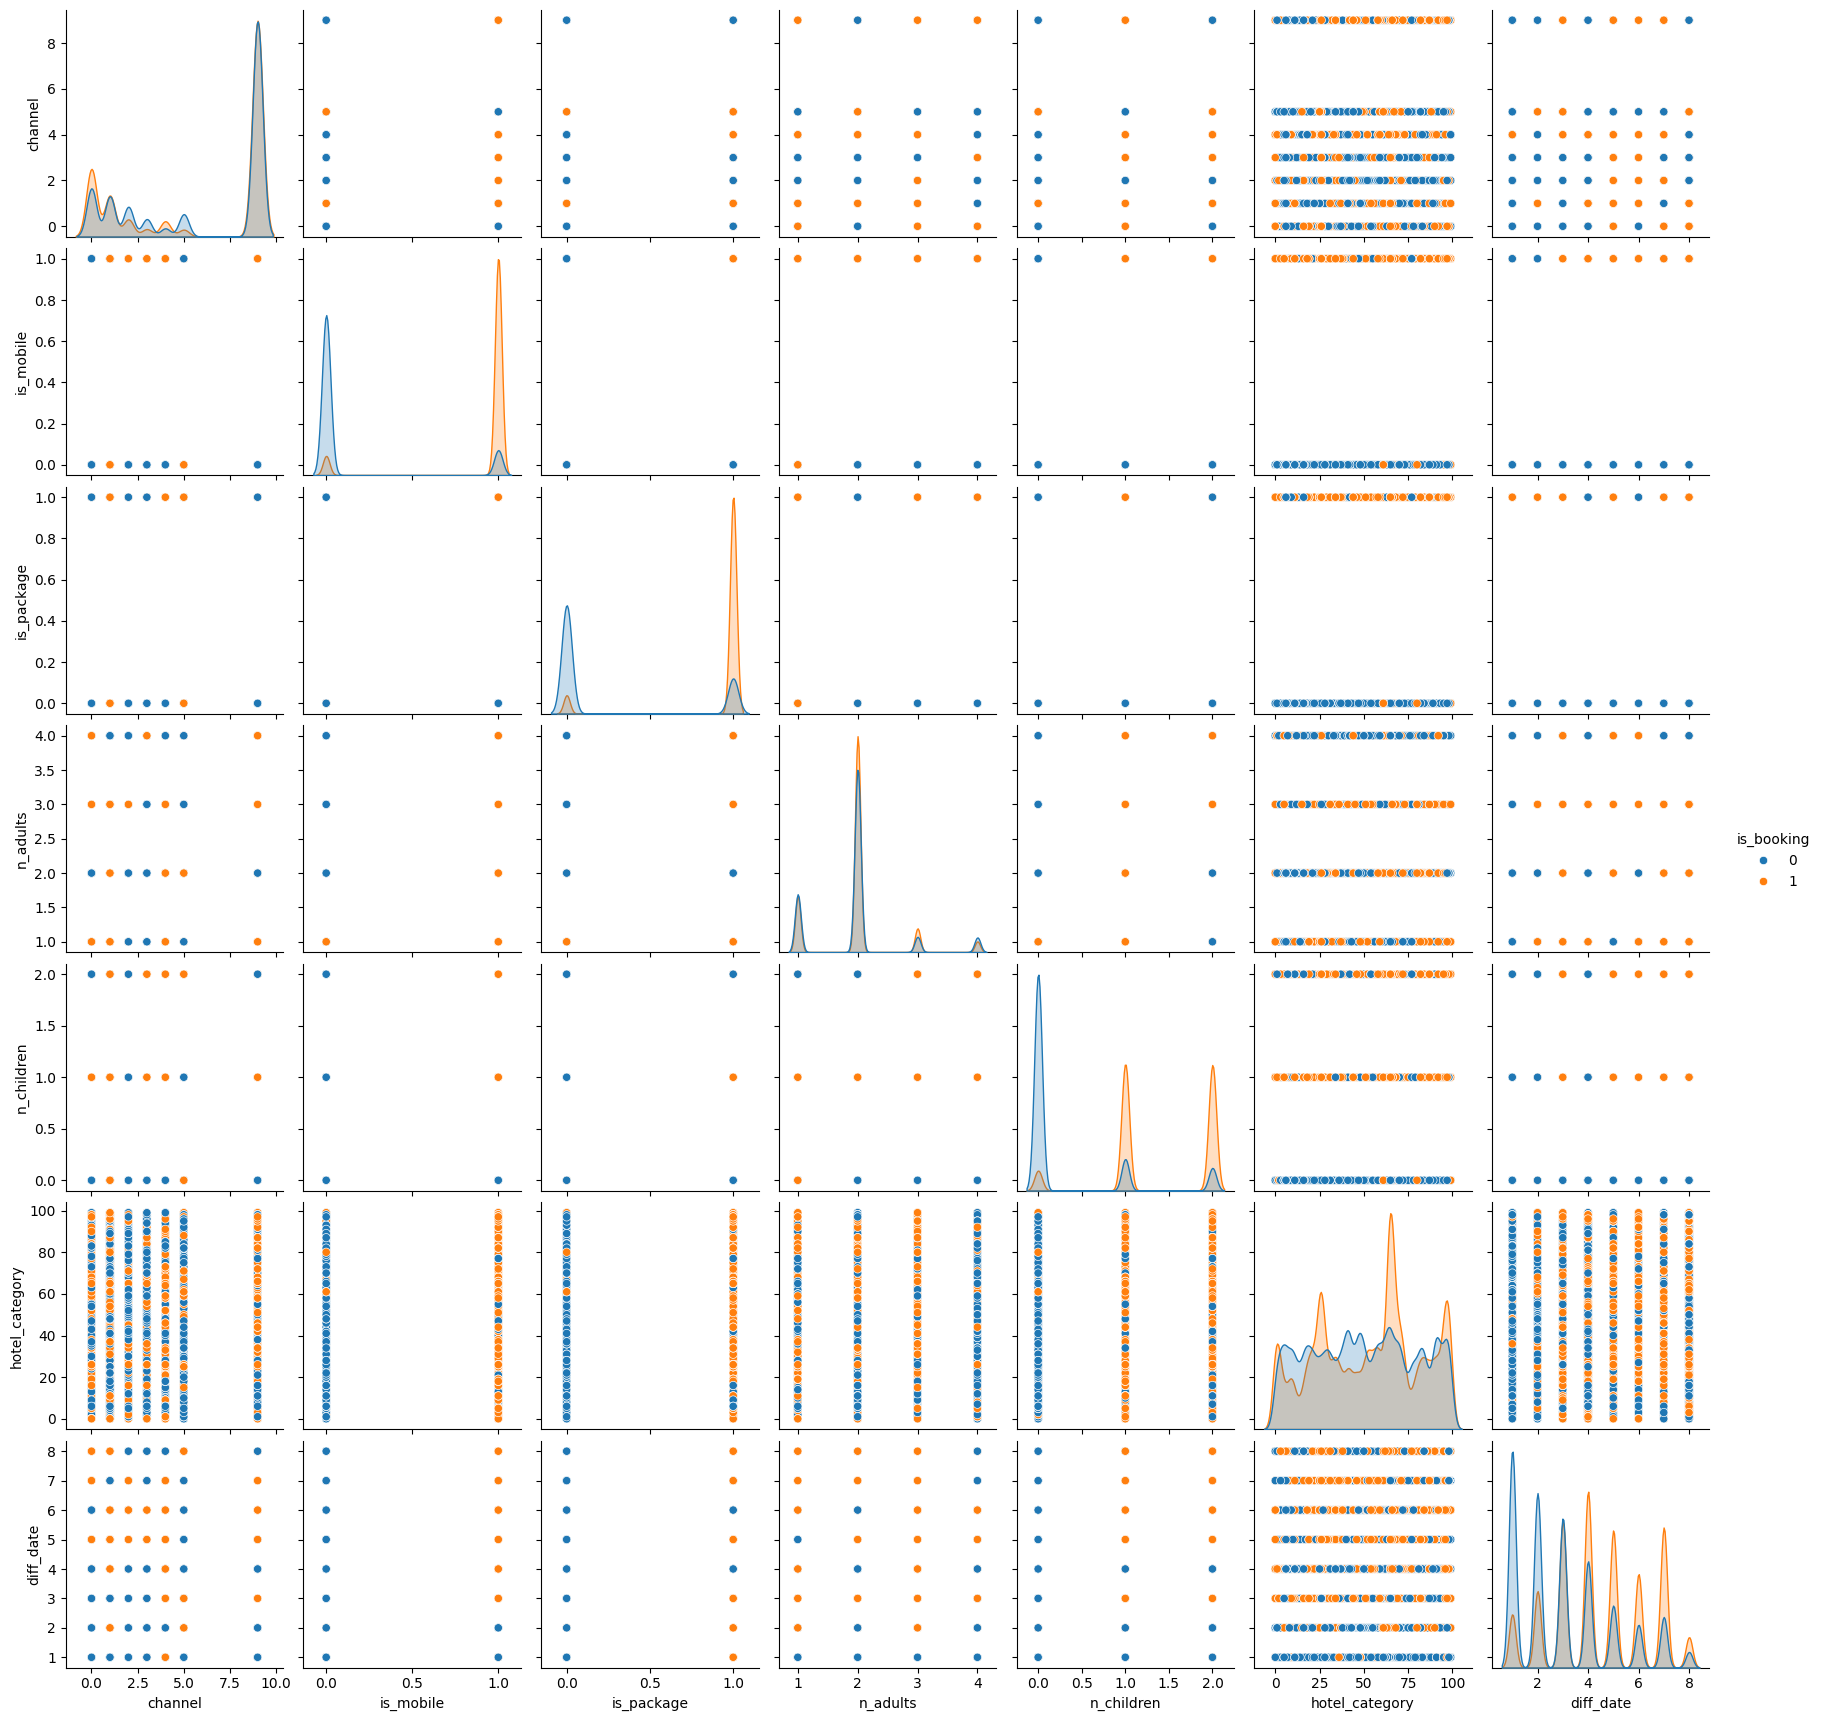

In [5]:
sns.pairplot(better_ds.sample(n = 1000000) , hue = 'is_booking')

In [ ]:
scores = pd.DataFrame(columns = ['precision' , 'recall' , 'f1 score' , 'confusion_matrix' , 'accuracy' , 'roc auc score' , 'Class 0 accuracy' , 'Class 1 accuracy' , 'average accuracy'])
scores_05 = cal_score(scores , Columns_to_drop , Threshold = 0.5 , train = better_ds , test = cleaned_test)
clear_output()

as we can see with defalut 0.5 threshold we wont get good results

In [128]:
scores_05

,precision,recall,f1 score,confusion_matrix,accuracy,roc auc score,Class 0 accuracy,Class 1 accuracy,average accuracy
"['is_mobile', 'is_booking']",0.061334,0.095683,0.074752,"[[396438, 61538], [38003, 4021]]",0.800918,0.480657,9.568342,86.563051,48.065697
"['is_package', 'is_booking']",0.048219,0.134875,0.071040,"[[346097, 111879], [36356, 5668]]",0.703530,0.445293,13.487531,75.570991,44.529261
"['n_children', 'is_booking']",0.075907,0.178636,0.106542,"[[366586, 91390], [34517, 7507]]",0.748186,0.487804,17.863602,80.044806,48.954204
"['is_booking', 'diff_date']",0.048384,0.187702,0.076936,"[[302834, 155142], [34136, 7888]]",0.621444,0.378131,18.770227,66.124426,42.447326
"['is_mobile', 'is_package', 'is_booking']",0.027484,0.012755,0.017424,"[[439010, 18966], [41488, 536]]",0.879092,0.536159,1.275462,95.858735,48.567098
"['is_mobile', 'n_children', 'is_booking']",0.053746,0.017704,0.026635,"[[444877, 13099], [41280, 744]]",0.891242,0.517682,1.770417,97.139806,49.455112
"['is_mobile', 'is_booking', 'diff_date']",0.042788,0.048567,0.045495,"[[412317, 45659], [39983, 2041]]",0.828716,0.570400,4.856749,90.030264,47.443506
"['is_package', 'n_children', 'is_booking']",0.033095,0.015444,0.021060,"[[439015, 18961], [41375, 649]]",0.879328,0.538965,1.544356,95.859827,48.702091
"['is_package', 'is_booking', 'diff_date']",0.048219,0.134875,0.071040,"[[346097, 111879], [36356, 5668]]",0.703530,0.510670,13.487531,75.570991,44.529261
"['n_children', 'is_booking', 'diff_date']",0.059270,0.103132,0.075278,"[[389187, 68789], [37690, 4334]]",0.787042,0.564246,10.313154,84.979781,47.646467


so we will calculate best threshold we can here with a model that i saved which trained on resampled dataset and find the best threshold and use it again to see if we get better results

In [8]:
model_check = keras.models.load_model('model.h5')

Tcheck = cleaned_test.drop(['hotel_category' , 'channel' , 'n_adults'] , axis = 1)
Tcheck['is_mobile'] = bool_to_binary(ds = Tcheck , column = 'is_mobile')
Tcheck['is_package'] = bool_to_binary(ds = Tcheck , column = 'is_package')
Tcheck['is_booking'] = bool_to_binary(ds = Tcheck , column = 'is_booking')

x_check = Tcheck.drop(['is_booking'] , axis = 1)
y_check = Tcheck['is_booking']

x_check = np.asarray(x_check , dtype = 'float32')
y_check = np.asarray(y_check , dtype = 'float32')

prediction = model_check.predict(x_check[ :500000])

preci , reca , thresh = precision_recall_curve(y_check[:500000] , prediction)
fscore = (2 * preci * reca) / (preci + reca)
ix = np.nanargmax(fscore)

TheThreshold = thresh[ix]
clear_output()
print(TheThreshold)

0.10408119


this plot doesnt look promising...

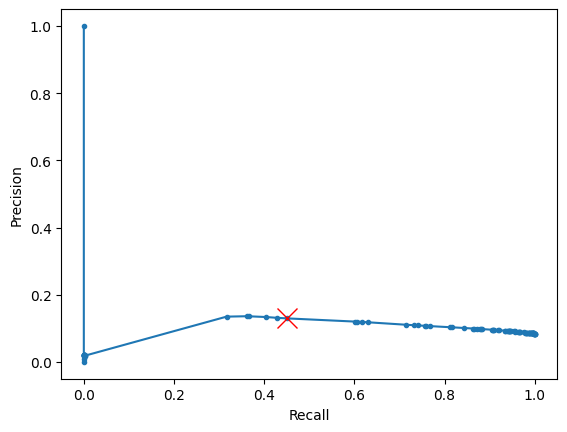

In [9]:
plt.plot(reca , preci , marker = '.')
plt.plot(reca[ix] , preci[ix] , 'rx' , markersize = 15)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
scores = pd.DataFrame(columns = ['precision' , 'recall' , 'f1 score' , 'confusion_matrix' , 'accuracy' , 'roc auc score' , 'Class 0 accuracy' , 'Class 1 accuracy' , 'average accuracy'])
TheScores = cal_score(scores , Columns_to_drop , Threshold = TheThreshold , train = better_ds , test = cleaned_test)
clear_output()

much better than 0.5 threshold. but the best this will give us is just close to model with imbalanced data which means that we didnt achieve what we had in mind

In [11]:
TheScores

,precision,recall,f1 score,confusion_matrix,accuracy,roc auc score,Class 0 accuracy,Class 1 accuracy,average accuracy
"['is_mobile', 'is_booking']",0.061334,0.095683,0.074752,"[[396438, 61538], [38003, 4021]]",0.800918,0.480657,9.568342,86.563051,48.065697
"['is_package', 'is_booking']",0.048219,0.134875,0.071040,"[[346097, 111879], [36356, 5668]]",0.703530,0.445293,13.487531,75.570991,44.529261
"['n_children', 'is_booking']",0.075907,0.178636,0.106542,"[[366586, 91390], [34517, 7507]]",0.748186,0.487804,17.863602,80.044806,48.954204
"['is_booking', 'diff_date']",0.084048,1.000000,0.155063,"[[0, 457976], [0, 42024]]",0.084048,0.378391,100.000000,0.000000,50.000000
"['is_mobile', 'is_package', 'is_booking']",0.027484,0.012755,0.017424,"[[439010, 18966], [41488, 536]]",0.879092,0.536159,1.275462,95.858735,48.567098
"['is_mobile', 'n_children', 'is_booking']",0.053746,0.017704,0.026635,"[[444877, 13099], [41280, 744]]",0.891242,0.519294,1.770417,97.139806,49.455112
"['is_mobile', 'is_booking', 'diff_date']",0.109184,0.488269,0.178461,"[[290564, 167412], [21505, 20519]]",0.622166,0.570400,48.826861,63.445246,56.136053
"['is_package', 'n_children', 'is_booking']",0.033095,0.015444,0.021060,"[[439015, 18961], [41375, 649]]",0.879328,0.538965,1.544356,95.859827,48.702091
"['is_package', 'is_booking', 'diff_date']",0.094066,0.562203,0.161166,"[[230437, 227539], [18398, 23626]]",0.508126,0.510530,56.220255,50.316392,53.268324
"['n_children', 'is_booking', 'diff_date']",0.106921,0.542833,0.178653,"[[267434, 190542], [19212, 22812]]",0.580492,0.564334,54.283267,58.394763,56.339015


# Isolation forest
***

now its time for our last resort. a algorithm made for finding anomalies. lets see how it works. first we train this on our imbalanced data and check the results

In [14]:
scores = pd.DataFrame(columns = ['precision' , 'recall' , 'f1 score' , 'confusion_matrix' , 'accuracy' , 'roc auc score' , 'Class 0 accuracy' , 'Class 1 accuracy' , 'average accuracy'])
isoF_Scores = cal_isoF(scores , Columns_to_drop , contamination = 0.22 , train = cleaned_ds , test = cleaned_test)
clear_output()

not good

In [15]:
isoF_Scores.sort_values(by = 'average accuracy')

,precision,recall,f1 score,confusion_matrix,accuracy,roc auc score,Class 0 accuracy,Class 1 accuracy,average accuracy
"['is_booking', 'diff_date']",0.042294,0.100133,0.059469,"[[362689, 95287], [37816, 4208]]",0.733794,0.553964,10.013326,79.193888,44.603607
"['is_package', 'is_booking', 'diff_date']",0.044516,0.104607,0.062454,"[[363621, 94355], [37628, 4396]]",0.736034,0.550710,10.460689,79.397392,44.929041
"['is_mobile', 'is_package', 'n_children', 'is_booking', 'diff_date']",0.051838,0.127974,0.073787,"[[359608, 98368], [36646, 5378]]",0.729972,0.543407,12.797449,78.521145,45.659297
"['is_package', 'n_children', 'is_booking', 'diff_date']",0.055355,0.141681,0.079607,"[[356369, 101607], [36070, 5954]]",0.724646,0.540090,14.168094,77.813903,45.990999
"['is_mobile', 'is_booking', 'diff_date']",0.053416,0.124310,0.074724,"[[365402, 92574], [36800, 5224]]",0.741252,0.538914,12.430992,79.786277,46.108634
"['is_mobile', 'is_package', 'n_children', 'is_booking']",0.059767,0.154198,0.086144,"[[356035, 101941], [35544, 6480]]",0.725030,0.534196,15.419760,77.740973,46.580367
"['is_mobile', 'is_package', 'is_booking', 'diff_date']",0.059169,0.144013,0.083876,"[[361744, 96232], [35972, 6052]]",0.735592,0.533056,14.401294,78.987545,46.694420
"['is_mobile', 'n_children', 'is_booking', 'diff_date']",0.060194,0.148034,0.085587,"[[360848, 97128], [35803, 6221]]",0.734138,0.532023,14.803446,78.791902,46.797674
"['is_mobile', 'n_children', 'is_booking']",0.061561,0.145774,0.086565,"[[364591, 93385], [35898, 6126]]",0.741434,0.529067,14.577384,79.609193,47.093289
"['is_mobile', 'is_booking']",0.061334,0.095683,0.074752,"[[396438, 61538], [38003, 4021]]",0.800918,0.519343,9.568342,86.563051,48.065697


now we check how this algorithm will work on our resampled data

In [10]:
scores = pd.DataFrame(columns = ['precision' , 'recall' , 'f1 score' , 'confusion_matrix' , 'accuracy' , 'roc auc score' , 'Class 0 accuracy' , 'Class 1 accuracy' , 'average accuracy'])
resampld_isoF_Scores = cal_isoF(scores , Columns_to_drop , contamination = 0.22 , train = better_ds , test = cleaned_test)
clear_output()

definitely better than before. its best results is near MLP

In [ ]:
resampld_isoF_Scores.sort_values(by = 'average accuracy')

,precision,recall,f1 score,confusion_matrix,accuracy,roc auc score,Class 0 accuracy,Class 1 accuracy,average accuracy
"['is_mobile', 'is_package', 'is_booking', 'diff_date']",0.057095,0.231154,0.091572,"[[297553, 160423], [32310, 9714]]",0.614534,0.559567,23.115363,64.971309,44.043336
"['is_mobile', 'is_package', 'n_children', 'is_booking', 'diff_date']",0.058102,0.238626,0.093451,"[[295412, 162564], [31996, 10028]]",0.610880,0.558168,23.862555,64.503817,44.183186
"['is_mobile', 'is_package', 'is_booking']",0.059798,0.205049,0.092593,"[[322491, 135485], [33407, 8617]]",0.662216,0.545392,20.504950,70.416572,45.460761
"['is_package', 'is_booking', 'diff_date']",0.056706,0.154602,0.082977,"[[349899, 108077], [35527, 6497]]",0.712792,0.540693,15.460213,76.401165,45.930689
"['is_mobile', 'is_booking', 'diff_date']",0.057385,0.160194,0.084500,"[[347395, 110581], [35292, 6732]]",0.708254,0.540631,16.019417,75.854412,45.936915
"['is_package', 'n_children', 'is_booking']",0.067017,0.282624,0.108343,"[[292629, 165347], [30147, 11877]]",0.609012,0.539207,28.262421,63.896143,46.079282
"['is_package', 'n_children', 'is_booking', 'diff_date']",0.066559,0.252879,0.105381,"[[308940, 149036], [31397, 10627]]",0.639134,0.536272,25.287931,67.457683,46.372807
"['is_mobile', 'n_children', 'is_booking', 'diff_date']",0.068798,0.270036,0.109658,"[[304378, 153598], [30676, 11348]]",0.631452,0.532674,27.003617,66.461561,46.732589
"['n_children', 'is_booking', 'diff_date']",0.062468,0.171521,0.091581,"[[349796, 108180], [34816, 7208]]",0.714008,0.532346,17.152104,76.378675,46.765389
"['is_mobile', 'is_package', 'n_children', 'is_booking']",0.072931,0.255021,0.113424,"[[321745, 136231], [31307, 10717]]",0.664924,0.521221,25.502094,70.253681,47.877888


# training best model we can afford
***

so we conclude that we only need `is_mobile` , `n_children` , `diff_date` and `is_package` to train the best model we can and its all we can afford so we drop columns which we dont need and doing categorical encoding on columns we need

In [108]:
df = cleaned_ds.drop(['hotel_category' , 'channel' , 'n_adults'] , axis = 1)
Test = cleaned_test.drop(['hotel_category' , 'channel' , 'n_adults'] , axis = 1)

Test['is_mobile'] = bool_to_binary(ds = Test , column = 'is_mobile')
Test['is_package'] = bool_to_binary(ds = Test , column = 'is_package')
Test['is_booking'] = bool_to_binary(ds = Test , column = 'is_booking')

c:\Users\msmj\anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


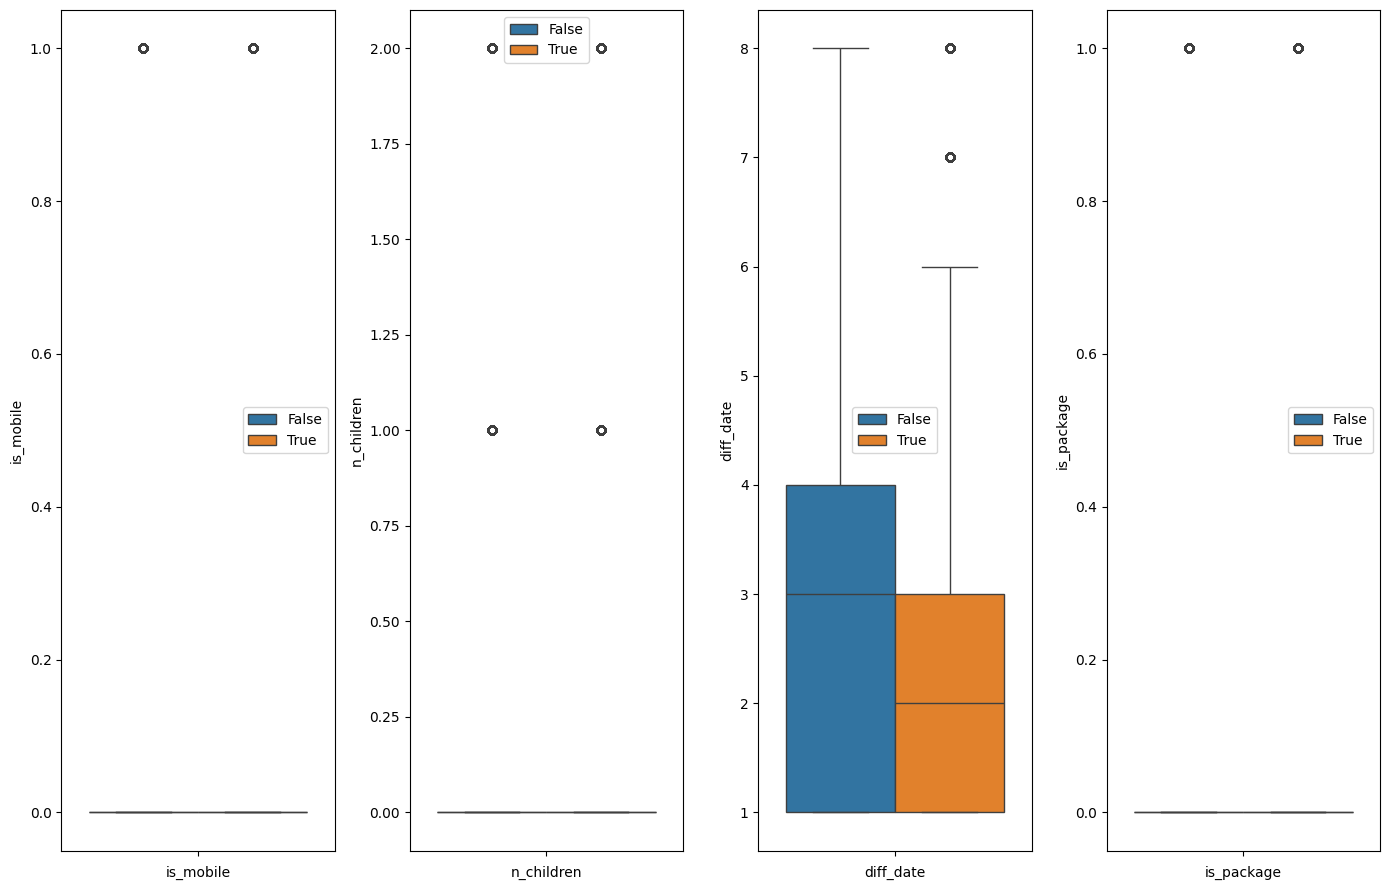

In [109]:
fig , [ax1 , ax2 , ax3 , ax4] = plt.subplots(nrows = 1 , ncols = 4)

sns.boxplot(df , y = 'is_mobile' , hue = 'is_booking' , ax = ax1)
sns.boxplot(df , y = 'n_children' , hue = 'is_booking' , ax = ax2)
sns.boxplot(df , y = 'diff_date' , hue = 'is_booking' , ax = ax3)
sns.boxplot(df , y = 'is_package' , hue = 'is_booking' , ax = ax4)

ax1.set_xlabel('is_mobile')
ax2.set_xlabel('n_children')
ax3.set_xlabel('diff_date')
ax4.set_xlabel('is_package')

ax1.legend(['False' , 'True'])
ax2.legend(['False' , 'True'])
ax3.legend(['False' , 'True'])
ax4.legend(['False' , 'True'])

fig.set_figwidth(14)
fig.set_figheight(9)

plt.tight_layout()
clear_output()
plt.show()

maybe because of how this pairplot is, decision tree will work well so we should train decision tree on this too and evaluate it. we'll see that decision tree will perform close to neural network on this dataset! this shows us its important to plot scatter plot no matter what cuz it gives us good info about dataset

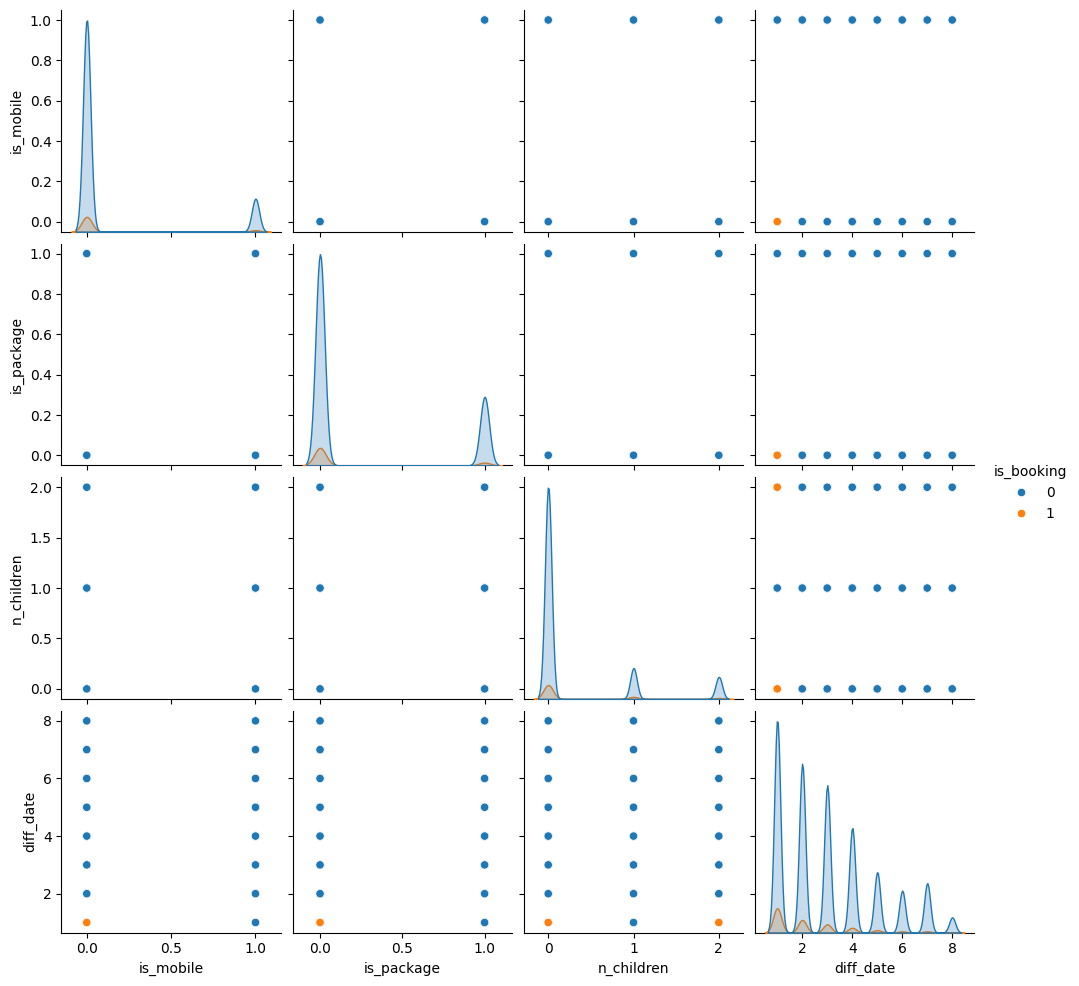

In [105]:
sns.pairplot(df.sample(n = 1000000) , hue = 'is_booking')

and we can see the cleaned version of our heatmap and its not that promising

<Axes: >

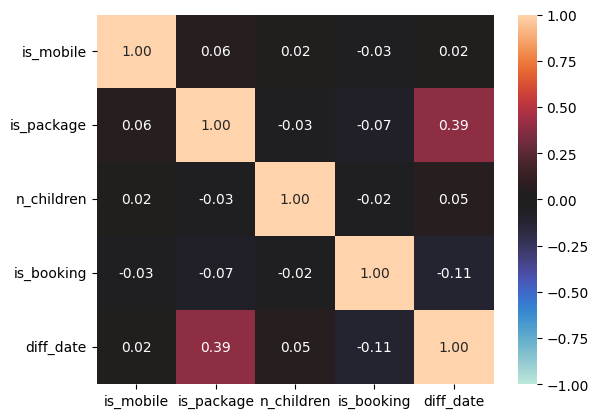

In [17]:
sns.heatmap(df.corr() , annot = True , vmin = -1 , fmt = ".2f" , center = 0)

In [18]:
df.describe()

,is_mobile,is_package,n_children,is_booking,diff_date
count,2.829079e+07,2.829079e+07,28290794.0,2.829079e+07,28290794.0
mean,1.322390e-01,2.357657e-01,0.279133,8.457447e-02,2.975752
std,3.387504e-01,4.244765e-01,0.602744,2.782474e-01,1.894687
min,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.0
25%,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.0
50%,0.000000e+00,0.000000e+00,0.0,0.000000e+00,3.0
75%,0.000000e+00,0.000000e+00,0.0,0.000000e+00,4.0
max,1.000000e+00,1.000000e+00,2.0,1.000000e+00,8.0


In [2]:
# with open('test.pkl' , 'wb') as pickle_out:
#     pickle.dump(Test , pickle_out)
#     pickle_out.close()

# with open('df.pkl' , 'wb') as pickle_out:
#     pickle.dump(df , pickle_out)
#     pickle_out.close()

with open('df.pkl' , 'rb') as pickle_in:
    df = pickle.load(pickle_in)
    pickle_in.close()

with open('test.pkl' , 'rb') as pickle_in:
    Test = pickle.load(pickle_in)
    pickle_in.close()

we'll separate our X , y data and change their dtype because neural network only accept `float32` as their input dtype

In [3]:
X = df.drop(['is_booking'] , axis = 1)
y = df['is_booking']
x_test = Test.drop(['is_booking'] , axis = 1)
y_test = Test['is_booking']

x_train = np.asarray(X , dtype = 'float32') # we'll turn'em into float32 cuz our model only works with this kind of dtype
y_train = np.asarray(y , dtype = 'float32')

x_test = np.asarray(x_test , dtype = 'float32')
y_test = np.asarray(y_test , dtype = 'float32')

# Neural network and it's results
***

now we create the a dataframe which we're gonna append our results to it

In [5]:
final_res = pd.DataFrame(columns = ['f1 score' , 'global accuracy' , 'average accuracy'])

and we make our model

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(300 , activation = 'relu' , kernel_initializer = 'he_normal' , input_shape = (4,)),
    # keras.layers.Dense(100 , activation = 'relu' , kernel_initializer = 'he_normal'),
    # keras.layers.Dense(200 , activation = 'relu' , kernel_initializer = 'he_normal'),
    keras.layers.Dense(300 , activation = 'relu' , kernel_initializer = 'he_normal'),
    keras.layers.Dense(100 , activation = 'relu' , kernel_initializer = 'he_normal'),
    # keras.layers.Dense(100 , activation = 'relu' , kernel_initializer = 'he_normal'),
    # keras.layers.Dense(200 , activation = 'relu' , kernel_initializer = 'he_normal'),
    # keras.layers.Dense(300 , activation = 'relu' , kernel_initializer = 'he_normal'),
    # keras.layers.Dense(100 , activation = 'relu' , kernel_initializer = 'he_normal'),
    keras.layers.Dense(1 , activation = 'sigmoid'),
])
model.compile(loss = 'binary_crossentropy' , optimizer = keras.optimizers.Adam(learning_rate = 0.01) , metrics = ['accuracy'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_269 (Dense)           (None, 300)               1500      
                                                                 
 dense_270 (Dense)           (None, 300)               90300     
                                                                 
 dense_271 (Dense)           (None, 100)               30100     
                                                                 
 dense_272 (Dense)           (None, 1)                 101       
                                                                 
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________


In [237]:
history = model.fit(x_train , y_train , batch_size = 1024 , epochs = 1)

26556/26556 [==============================] - 93s 3ms/step - loss: 0.2789 - accuracy: 0.9162


In [ ]:
# model.save('model.h5')
# model = keras.models.load_model('model.h5')

In [244]:
prediction = model.predict(x_test[ :500000])

15625/15625 [==============================] - 18s 1ms/step


In [ ]:
roc = roc_auc_score(y_test[ :500000] , prediction)
print(f'roc auc score: {roc}\n')

roc auc score: 0.6453425397107365


In [ ]:
prediction_2 = np.where(prediction >= TheThreshold2 , 1 , 0)

conf = confusion_matrix(y_test[ :500000] , prediction_2)
mlp_conf = conf
f1 = f1_score(y_test[ :500000] , prediction_2)
acc = accuracy_score(y_test[ :500000] , prediction_2)
avg_acc = (((conf[0][0] / (conf[0][0] + conf[0][1])) + (conf[1][1] / (conf[1][1] + conf[1][0]))) / 2) * 100 

print(f'f1_score: {f1}' , '\n')
print('confusion maxtrix:')
print(conf , '\n')
print(f'accuracy_score: {acc}')
print(f'\naverage accuracy: {avg_acc}')

f1_score: 0.21250245427496942 

confusion maxtrix:
[[322472 135736]
 [ 20687  21105]] 

accuracy_score: 0.687154

average accuracy: 60.43843391652809


In [20]:
# we add the results to our dataframe which we contain the results
final_res.loc['Neural network'] = [round(f1 , 4) , round(acc , 4) , round(avg_acc , 4)]

## Knn and it's results
***

we define the model with 7 neighbors, 2 more than its default

In [19]:
knn_model = KNeighborsClassifier(n_neighbors = 7 , weights = 'distance' , n_jobs = -1)
knn_model.fit(x_train , y_train )

KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance')

knn is so slow i needed to only predict with first 500 rows in test. it 100 times less that default so its metrics and all cant be trusted

In [ ]:
knn_prediction = knn_model.predict_proba(x_test[ :5000])
knn_prediction_2 = np.where(knn_prediction[: , 1] >= TheThreshold2 , 1 , 0)

conf = confusion_matrix(y_test[ :5000] , knn_prediction_2)
knn_conf = conf
f1 = f1_score(y_test[ :5000] , knn_prediction_2)
acc = accuracy_score(y_test[ :5000] , knn_prediction_2)
avg_acc = (((conf[0][0] / (conf[0][0] + conf[0][1])) + (conf[1][1] / (conf[1][1] + conf[1][0]))) / 2) * 100 

print(f'f1_score: {f1}' , '\n')
print('confusion maxtrix:')
print(conf , '\n')
print(f'accuracy_score: {acc}')
print(f'\naverage accuracy: {avg_acc}')

f1_score: 0.1167192429022082 

confusion maxtrix:
[[3209 1383]
 [ 297  111]] 

accuracy_score: 0.664

average accuracy: 48.54414326706292


In [ ]:
final_res.loc['Knn'] = [round(f1 , 4) , round(acc , 4) , round(avg_acc , 4)]

## Logistic regression and it's results
***

we gotta define the logistic model and fit it here

In [21]:
Lreg = LogisticRegression(n_jobs = -1)
Lreg_model = Lreg.fit(x_train , y_train)

and calculate its metric here

In [ ]:
Lreg_prediction = Lreg_model.predict_proba(x_test[ :2500000])
Lreg_prediction_2 = np.where(Lreg_prediction[: , 1] >= TheThreshold2 , 1 , 0)

conf = confusion_matrix(y_test[ :2500000] , Lreg_prediction_2)
log_conf = conf
f1 = f1_score(y_test[ :2500000] , Lreg_prediction_2)
acc = accuracy_score(y_test[ :2500000] , Lreg_prediction_2)
avg_acc = (((conf[0][0] / (conf[0][0] + conf[0][1])) + (conf[1][1] / (conf[1][1] + conf[1][0]))) / 2) * 100 

print(f'f1_score: {f1}' , '\n')
print('confusion maxtrix:')
print(conf , '\n')
print(f'accuracy_score: {acc}')
print(f'\naverage accuracy: {avg_acc}')

f1_score: 0.09681588788439895 

confusion maxtrix:
[[1451612  837419]
 [ 157637   53332]] 

accuracy_score: 0.6019776

average accuracy: 44.34777392706317


In [ ]:
final_res.loc['Logistic regression'] = [round(f1 , 4) , round(acc , 4) , round(avg_acc , 4)]

## Decision tree and it's results
***

here we train our decision tree and fit and plot the tree plot

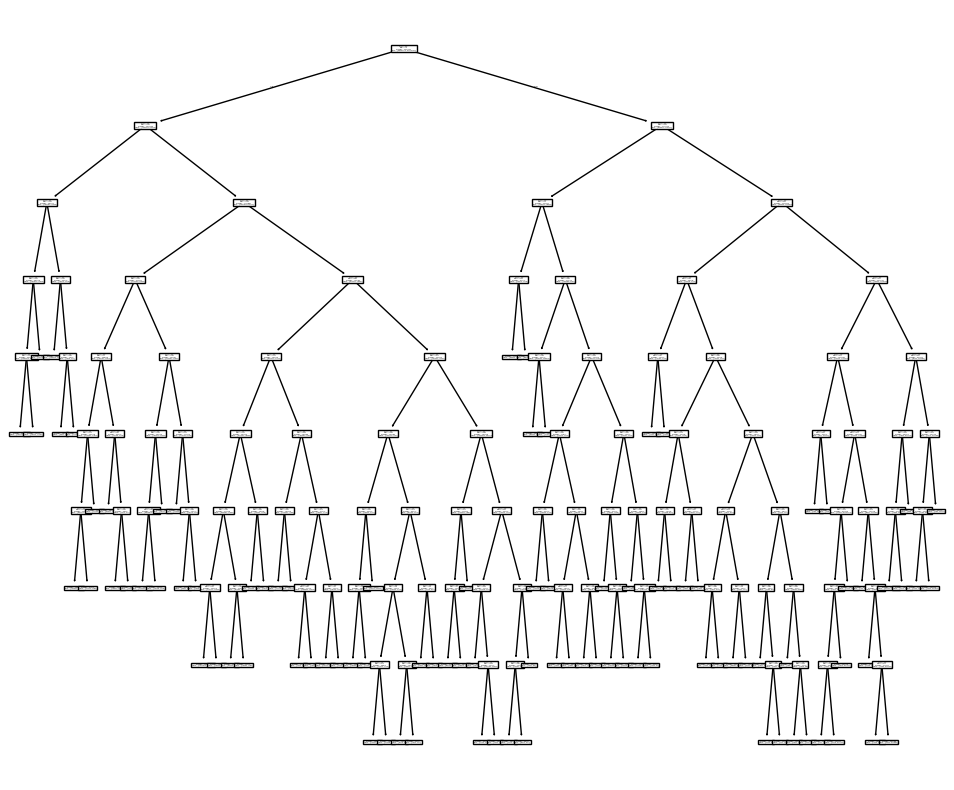

In [23]:
DT = DecisionTreeClassifier()
DT_model = DT.fit(x_train , y_train)

fig , ax = plt.subplots(ncols=1 , nrows=1)
plot_tree(DT_model , ax = ax)
fig.set_figwidth(12)
fig.set_figheight(10)
plt.show()

In [ ]:
DT_prediction = DT_model.predict_proba(x_test[ :2500000])
DT_prediction_2 = np.where(DT_prediction[: , 1] >= TheThreshold2 , 1 , 0)

conf = confusion_matrix(y_test[ :2500000] , DT_prediction_2)
decision_conf = conf
f1 = f1_score(y_test[ :2500000] , DT_prediction_2)
acc = accuracy_score(y_test[ :2500000] , DT_prediction_2)
avg_acc = (((conf[0][0] / (conf[0][0] + conf[0][1])) + (conf[1][1] / (conf[1][1] + conf[1][0]))) / 2) * 100 

print(f'f1_score: {f1}' , '\n')
print('confusion maxtrix:')
print(conf , '\n')
print(f'accuracy_score: {acc}')
print(f'\naverage accuracy: {avg_acc}')

f1_score: 0.19931341355469964 

confusion maxtrix:
[[1747295  541736]
 [ 127654   83315]] 

accuracy_score: 0.732244

average accuracy: 57.912487899679746


In [ ]:
final_res.loc['Decision tree'] = [round(f1 , 4) , round(acc , 4) , round(avg_acc , 4)]

# Random forest and it's results
***

we initialize our random forest model and we set n_estimators to 120 because it worked well on isolation forest too.

In [111]:
randomF = RandomForestClassifier(n_estimators = 120)
randomF_model = randomF.fit(X = x_train , y = y_train)

and this worked surprisingly well

In [ ]:
randomF_prediction = randomF_model.predict_proba(x_test[ :2500000])
randomF_prediction_2 = np.where(randomF_prediction[: , 1] >= TheThreshold2 , 1 , 0)

conf = confusion_matrix(y_test[ :2500000] , randomF_prediction_2)
randF_conf = conf
f1 = f1_score(y_test[ :2500000] , randomF_prediction_2)
acc = accuracy_score(y_test[ :2500000] , randomF_prediction_2)
avg_acc = (((conf[0][0] / (conf[0][0] + conf[0][1])) + (conf[1][1] / (conf[1][1] + conf[1][0]))) / 2) * 100 

print(f'f1_score: {f1}' , '\n')
print('confusion maxtrix:')
print(conf , '\n')
print(f'accuracy_score: {acc}')
print(f'\naverage accuracy: {avg_acc}')

f1_score: 0.211262716302167 

confusion maxtrix:
[[1739970  550941]
 [ 119324   89765]] 

accuracy_score: 0.731894

average accuracy: 59.44124353782748


In [ ]:
final_res.loc['Random forest'] = [round(f1 , 4) , round(acc , 4) , round(avg_acc , 4)]

## SVM and it's results
***

we want to train a SVM with linear kernel and one with rbf but accoding to the document:
> *The implementation is based on libsvm. The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets consider using LinearSVC or SGDClassifier instead*

so we cant train this big dataset on simple svc so what we should do is use linearSVC as document said and for linear kernel and use kernel approximation for rbf and train on that transformed data

In [25]:
svm = LinearSVC()
svm_model = svm.fit(x_train , y_train)

there is no predict probablity of classes for svm so we will stick with 0.5 threshold

In [ ]:
svm_prediction = svm_model.predict(x_test[ :2500000])

conf = confusion_matrix(y_test[ :2500000] , svm_prediction)
svm_conf = conf
f1 = f1_score(y_test[ :2500000] , svm_prediction)
acc = accuracy_score(y_test[ :2500000] , svm_prediction)
avg_acc = (((conf[0][0] / (conf[0][0] + conf[0][1])) + (conf[1][1] / (conf[1][1] + conf[1][0]))) / 2) * 100 

print(f'f1_score: {f1}' , '\n')
print('confusion maxtrix:')
print(conf , '\n')
print(f'overall accuracy_score: {acc}')
print(f'\naverage accuracy: {avg_acc}')

f1_score: 0.036460327149700475 

confusion maxtrix:
[[2120436  168595]
 [ 203921    7048]] 

overall accuracy_score: 0.8509936

average accuracy: 47.98771575449381


In [ ]:
final_res.loc['Svm'] = [round(f1 , 4) , round(acc , 4) , round(avg_acc , 4)]

and for rbf kernel i tried the kernel approximation but was too heavy for my pc

# results
***

,f1 score,global accuracy,average accuracy
neural network,0.2125,0.6872,60.4384
knn,0.1167,0.6640,48.5441
logistic regression,0.0968,0.6020,44.3477
Decision tree,0.1993,0.7322,57.9125
Random forest,0.2113,0.7319,59.4412
Svm,0.0365,0.8510,47.9877


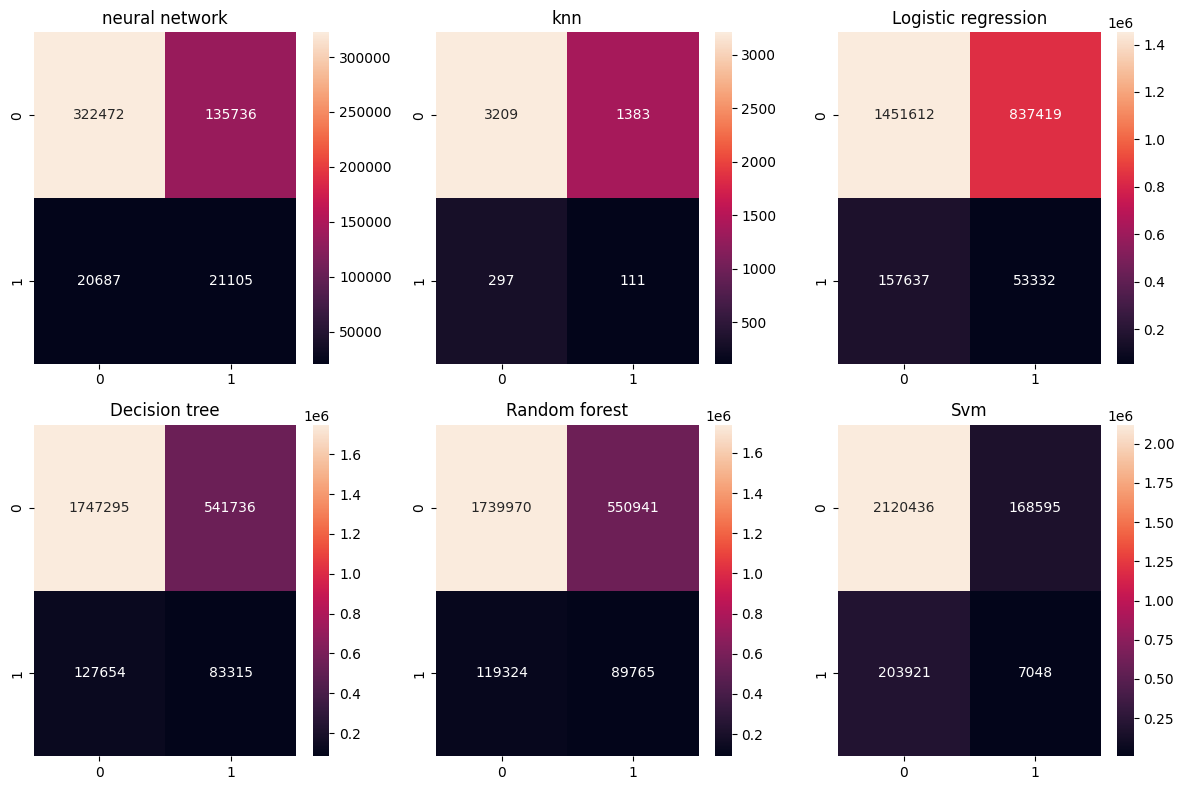

In [55]:
display(final_res)

fig , [[ax1 , ax2 , ax3] , [ax4 , ax5 , ax6]] = plt.subplots(nrows = 2 , ncols = 3)

sns.heatmap(mlp_conf , annot = True , fmt = '.0f' , ax = ax1)
sns.heatmap(knn_conf , annot = True , fmt = '.0f' , ax = ax2)
sns.heatmap(log_conf , annot = True , fmt = '.0f' , ax = ax3)
sns.heatmap(decision_conf , annot = True , fmt = '.0f' , ax = ax4)
sns.heatmap(randF_conf , annot = True , fmt = '.0f' , ax = ax5)
sns.heatmap(svm_conf , annot = True , fmt = '.0f' , ax = ax6)

ax1.set_title('neural network')
ax2.set_title('knn')
ax3.set_title('Logistic regression')
ax4.set_title('Decision tree')
ax5.set_title('Random forest')
ax6.set_title('Svm')

fig.set_figwidth(12)
fig.set_figheight(8)
plt.tight_layout()
plt.show()

# so neural network is our chosen model!